In [1]:
import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import skew
from scipy.spatial.distance import cityblock
import matplotlib.pyplot as plt
import seaborn as sns
from scgenome.cnplot import plot_clustered_cell_cn_matrix, plot_cell_cn_profile

from scdna_replication_tools.compute_consensus_clone_profiles import compute_consensus_clone_profiles
from scdna_replication_tools.assign_s_to_clones import assign_s_to_clones


In [3]:
cn_s = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig4/cn_s.tsv', sep='\t')
cn_g1 = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig4/cn_g1.tsv', sep='\t')
cn_g2 = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig4/cn_g2.tsv', sep='\t')

cn_g = pd.concat([cn_g1, cn_g2], ignore_index=True)

cn_g.head()

cell_id chr    start      end        gc  reads  state  \
0  SA1044-A96139A-R03-C07   1  1500001  2000000  0.539498  561.0    2.0   
1  SA1044-A96139A-R03-C07   1  2000001  2500000  0.594508  591.0    2.0   
2  SA1044-A96139A-R03-C07   1  3000001  3500000  0.584572  574.0    2.0   
3  SA1044-A96139A-R03-C07   1  4000001  4500000  0.482574  603.0    2.0   
4  SA1044-A96139A-R03-C07   1  4500001  5000000  0.481828  608.0    2.0   

       copy         rpm sample_id library_id cell_cycle_state  quality  \
0  1.889549  154.559292    SA1044    A96139A               G1    0.996   
1  2.072884  162.824495    SA1044    A96139A               G1    0.996   
2  1.989477  158.140880    SA1044    A96139A               G1    0.996   
3  2.072915  166.130576    SA1044    A96139A               G1    0.996   
4  2.091552  167.508110    SA1044    A96139A               G1    0.996   

   total_mapped_reads_hmmcopy  breakpoints  
0                   3700925.0         60.0  
1                   3700925.0         60.0  
2                   3700925.0         60.0  
3                   3700925.0         60.0  
4                   3700925.0         60.0

Subset to just 400 loci on chr1 and a random sampling of 300 cells

In [4]:
num_cells = 300
num_loci = 400

In [5]:
# subset based on loci
def subset_loci(cn, chrom="1", num_loci=400):
    cn = cn.query('chr=="{}"'.format(chrom))
    cutoff = cn[['start']].drop_duplicates().values[num_loci]
    cn = cn.query('start<{}'.format(cutoff))
    return cn

cn_s = subset_loci(cn_s, num_loci=num_loci)
cn_g = subset_loci(cn_g, num_loci=num_loci)

print(cn_s[['chr', 'start']].drop_duplicates().shape)
print(cn_g[['chr', 'start']].drop_duplicates().shape)
cn_s[['chr', 'start']].drop_duplicates().head()

(400, 2)
(400, 2)


chr    start
0   1  1500001
1   1  2000001
2   1  3000001
3   1  4000001
4   1  4500001

In [6]:
# subset based on cells
def subset_cells(cn, num_cells=300):
    cells_to_keep = np.random.choice(cn['cell_id'].unique(), num_cells, replace=False)
    cn = cn.loc[cn['cell_id'].isin(cells_to_keep)].reset_index(drop=True)
    return cn

cn_s = subset_cells(cn_s, num_cells=num_cells)
cn_g = subset_cells(cn_g, num_cells=num_cells)

cn_s.head()

cell_id chr    start      end        gc  reads  state  \
0  SA1044-A96139A-R03-C36   1  1500001  2000000  0.539498  496.0    2.0   
1  SA1044-A96139A-R03-C36   1  2000001  2500000  0.594508  564.0    2.0   
2  SA1044-A96139A-R03-C36   1  3000001  3500000  0.584572  643.0    2.0   
3  SA1044-A96139A-R03-C36   1  4000001  4500000  0.482574  629.0    2.0   
4  SA1044-A96139A-R03-C36   1  4500001  5000000  0.481828  606.0    2.0   

       copy         rpm sample_id library_id cell_cycle_state  quality  \
0  1.599267  130.279847    SA1044    A96139A                S      1.0   
1  2.017618  148.140794    SA1044    A96139A                S      1.0   
2  2.240401  168.891011    SA1044    A96139A                S      1.0   
3  2.001553  165.213757    SA1044    A96139A                S      1.0   
4  1.929176  159.172555    SA1044    A96139A                S      1.0   

   total_mapped_reads_hmmcopy  breakpoints  
0                   3882694.0        122.0  
1                   3882694.0        122.0  
2                   3882694.0        122.0  
3                   3882694.0        122.0  
4                   3882694.0        122.0

In [7]:
cn_s_metrics = cn_s[[
    'cell_id', 'sample_id', 'library_id', 'cell_cycle_state', 
    'quality', 'total_mapped_reads_hmmcopy', 'breakpoints'
]].drop_duplicates()

cn_g_metrics = cn_g[[
    'cell_id', 'sample_id', 'library_id', 'cell_cycle_state', 
    'quality', 'total_mapped_reads_hmmcopy', 'breakpoints'
]].drop_duplicates()

print(cn_s_metrics.library_id.value_counts())
print(cn_g_metrics.library_id.value_counts())

A96139A    107
A90553C     81
A96147A     56
A73044A     56
Name: library_id, dtype: int64
A96147A    81
A90553C    79
A96139A    71
A73044A    69
Name: library_id, dtype: int64


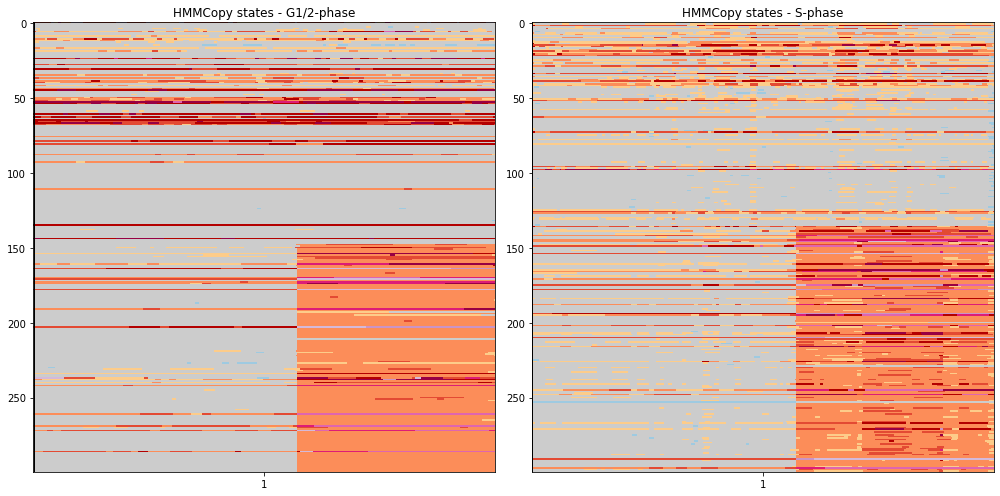

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

plot_clustered_cell_cn_matrix(ax[0], cn_g, 'state', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')
plot_clustered_cell_cn_matrix(ax[1], cn_s, 'state', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')

ax[0].set_title('HMMCopy states - G1/2-phase')
ax[1].set_title('HMMCopy states - S-phase')
plt.show()

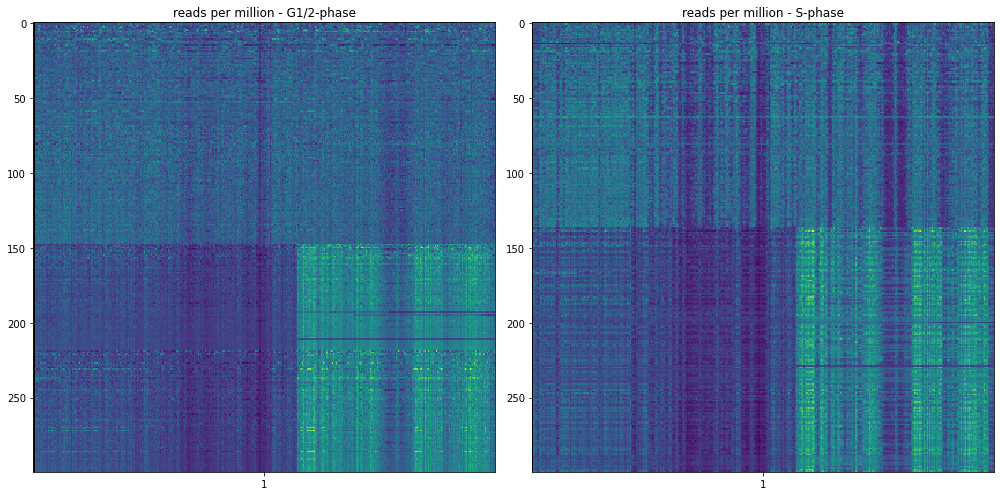

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

plot_clustered_cell_cn_matrix(ax[0], cn_g, 'rpm', max_cn=None, raw=True, cmap='viridis', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')
plot_clustered_cell_cn_matrix(ax[1], cn_s, 'rpm', max_cn=None, raw=True, cmap='viridis', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')

ax[0].set_title('reads per million - G1/2-phase')
ax[1].set_title('reads per million - S-phase')
plt.show()

Create new column `rpm2` in which all cells have the same number of reads within the 300 loci subset of interest. There should be ~80k reads for these 300 loci if the whole genome has 1 million reads.

This way all cells have the same effective coverage which means `u` is just accounting for ploidy.

In [10]:
def compute_rpm2(cn):
    for cell_id, cell_cn in cn.groupby('cell_id'):
        x = cell_cn['rpm'].values
        rpm2 = x * 8e4 / sum(x)
        cn.loc[cell_cn.index, 'rpm2'] = rpm2
    return cn

cn_s = compute_rpm2(cn_s)
cn_g = compute_rpm2(cn_g)


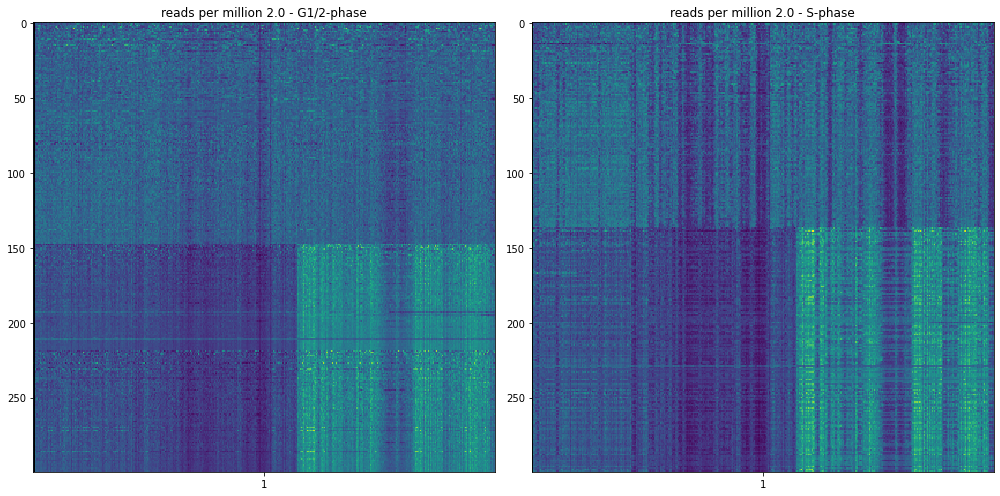

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

plot_clustered_cell_cn_matrix(ax[0], cn_g, 'rpm2', max_cn=None, raw=True, cmap='viridis', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')
plot_clustered_cell_cn_matrix(ax[1], cn_s, 'rpm2', max_cn=None, raw=True, cmap='viridis', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')

ax[0].set_title('reads per million 2.0 - G1/2-phase')
ax[1].set_title('reads per million 2.0 - S-phase')
plt.show()

Say that each S-phase cell's clone_id is the same as its sample_id. We cannot use `compute_consensus_clone_profiles()` and `assign_s_to_clones()` in this toy example because the lack of CNAs across the whole genome makes it more challenging to assign individual S-phase cells to the correct consensus profile.

In [12]:
cn_s['clone_id'] = cn_s['sample_id']
cn_g['clone_id'] = cn_g['sample_id']
cn_s.head()

cell_id chr    start      end        gc  reads  state  \
0  SA1044-A96139A-R03-C36   1  1500001  2000000  0.539498  496.0    2.0   
1  SA1044-A96139A-R03-C36   1  2000001  2500000  0.594508  564.0    2.0   
2  SA1044-A96139A-R03-C36   1  3000001  3500000  0.584572  643.0    2.0   
3  SA1044-A96139A-R03-C36   1  4000001  4500000  0.482574  629.0    2.0   
4  SA1044-A96139A-R03-C36   1  4500001  5000000  0.481828  606.0    2.0   

       copy         rpm sample_id library_id cell_cycle_state  quality  \
0  1.599267  130.279847    SA1044    A96139A                S      1.0   
1  2.017618  148.140794    SA1044    A96139A                S      1.0   
2  2.240401  168.891011    SA1044    A96139A                S      1.0   
3  2.001553  165.213757    SA1044    A96139A                S      1.0   
4  1.929176  159.172555    SA1044    A96139A                S      1.0   

   total_mapped_reads_hmmcopy  breakpoints        rpm2 clone_id  
0                   3882694.0        122.0  182.114418   SA1044  
1                   3882694.0        122.0  207.081717   SA1044  
2                   3882694.0        122.0  236.087845   SA1044  
3                   3882694.0        122.0  230.947518   SA1044  
4                   3882694.0        122.0  222.502696   SA1044

### Convert dataframes into appropriate tensors much like `pyro_infer_scRT.process_input_data()`

In [13]:
def process_input_data(
    cn_s, cn_g1, input_col='rpm', cell_col='cell_id', gc_col='gc',
    chr_col='chr', start_col='start', cn_state_col='state', rt_prior_col=None
):
    # sort rows by correct genomic ordering
    cn_g1 = sort_by_cell_and_loci(cn_g1, chr_col=chr_col, start_col=start_col, cell_col=cell_col)
    cn_s = sort_by_cell_and_loci(cn_s, chr_col=chr_col, start_col=start_col, cell_col=cell_col)

    # drop any row where read count input is NaN
    cn_g1 = cn_g1[cn_g1[input_col].notna()]
    cn_s = cn_s[cn_s[input_col].notna()]

    # pivot to 2D matrix where each row is a unique cell, columns are loci
    cn_g1_reads_df = cn_g1.pivot_table(index=cell_col, columns=[chr_col, start_col], values=input_col)
    cn_g1_states_df = cn_g1.pivot_table(index=cell_col, columns=[chr_col, start_col], values=cn_state_col)
    cn_s_reads_df = cn_s.pivot_table(index=cell_col, columns=[chr_col, start_col], values=input_col)
    cn_s_states_df = cn_s.pivot_table(index=cell_col, columns=[chr_col, start_col], values=cn_state_col)

    cn_g1_reads_df = cn_g1_reads_df.dropna()
    cn_g1_states_df = cn_g1_states_df.dropna()
    cn_s_reads_df = cn_s_reads_df.dropna()
    cn_s_states_df = cn_s_states_df.dropna()

    assert cn_g1_states_df.shape == cn_g1_reads_df.shape
    assert cn_s_reads_df.shape[1] == cn_g1_reads_df.shape[1]

    cn_g1_reads_df = cn_g1_reads_df.T
    cn_g1_states_df = cn_g1_states_df.T
    cn_s_reads_df = cn_s_reads_df.T
    cn_s_states_df = cn_s_states_df.T

    # convert to tensor and unsqueeze the data dimension
    # convert to int64 before float32 to ensure that all values are rounded to the nearest int
    cn_g1_reads = torch.tensor(cn_g1_reads_df.values).to(torch.int64).to(torch.float32)
    cn_g1_states = torch.tensor(cn_g1_states_df.values).to(torch.int64).to(torch.float32)
    cn_s_reads = torch.tensor(cn_s_reads_df.values).to(torch.int64).to(torch.float32)
    cn_s_states = torch.tensor(cn_s_states_df.values).to(torch.int64).to(torch.float32)

    # get tensor of library_id index
    # need this because each library will have unique gc params
    libs_s, libs_g1 = get_libraries_tensor(cn_s, cn_g1)

    # make sure there's one library index per cell
    assert libs_s.shape[0] == cn_s_reads.shape[1]
    assert libs_g1.shape[0] == cn_g1_reads.shape[1]

    # get tensor for GC profile
    gc_profile = cn_s[[chr_col, start_col, gc_col]].drop_duplicates()
    gc_profile = gc_profile.dropna()
    gc_profile = torch.tensor(gc_profile[gc_col].values).to(torch.float32)

    # get tensor for rt prior if provided
    if (rt_prior_col is not None) and (rt_prior_col in cn_s.columns):
        rt_prior_profile = cn_s[[chr_col, start_col, rt_prior_col]].drop_duplicates()
        rt_prior_profile = rt_prior_profile.dropna()
        rt_prior_profile = torch.tensor(rt_prior_profile[rt_prior_col].values).unsqueeze(-1).to(torch.float32)
        rt_prior_profile = convert_rt_prior_units(rt_prior_profile)
        assert cn_s_reads.shape[0] == gc_profile.shape[0] == rt_prior_profile.shape[0]
    else:
        rt_prior_profile = None

    return cn_g1_reads_df, cn_g1_states_df, cn_s_reads_df, cn_s_states_df, cn_g1_reads, cn_g1_states, cn_s_reads, cn_s_states, gc_profile, rt_prior_profile, libs_g1, libs_s


def sort_by_cell_and_loci(cn, chr_col='chr', start_col='start', cell_col='cell_id'):
    """ Sort long-form dataframe so each cell follows correct genomic ordering """
    cn[chr_col] = cn[chr_col].astype('category')
    chr_order = [str(i+1) for i in range(22)]
    chr_order.append('X')
    chr_order.append('Y')
    cn[chr_col] = cn[chr_col].cat.set_categories(chr_order)
    cn = cn.sort_values(by=[cell_col, chr_col, start_col])
    return cn


def get_libraries_tensor(cn_s, cn_g1, cell_col='cell_id', library_col='library_id'):
    """ Create a tensor of integers representing the unique library_id of each cell. """
    libs_s = cn_s[[cell_col, library_col]].drop_duplicates()
    libs_g1 = cn_g1[[cell_col, library_col]].drop_duplicates()

    # get all unique library ids found across cells of both cell cycle phases
    all_library_ids = pd.concat([libs_s, libs_g1])[library_col].unique()

    num_libraries = int(len(all_library_ids))

    # replace library_id strings with integer values
    for i, library_id in enumerate(all_library_ids):
        libs_s[library_col].replace(library_id, i, inplace=True)
        libs_g1[library_col].replace(library_id, i, inplace=True)

    # convert to tensors of type int (ints needed to index other tensors)
    libs_s = torch.tensor(libs_s[library_col].values).to(torch.int64)
    libs_g1 = torch.tensor(libs_g1[library_col].values).to(torch.int64)

    return libs_s, libs_g1


def convert_rt_prior_units(rt_prior_profile):
    """ Make sure that early RT regions are close to 1, late RT regions are close to 0 """
    rt_prior_profile = rt_prior_profile / max(rt_prior_profile)
    return rt_prior_profile

In [14]:
cn_g1_reads_df, cn_g1_states_df, cn_s_reads_df, cn_s_states_df, \
    cn_g1_reads, cn_g1_states, cn_s_reads, cn_s_states, \
    gc_profile, rt_prior_profile, libs_g1, libs_s = process_input_data(cn_s, cn_g, input_col='rpm2')

In [15]:
cn_s_reads

tensor([[182., 154., 242.,  ..., 317., 233., 220.],
        [207., 181., 230.,  ..., 179., 239., 186.],
        [236., 184., 183.,  ..., 233., 152., 187.],
        ...,
        [227., 195., 226.,  ..., 108., 212., 127.],
        [154., 208., 214.,  ...,  57.,  61.,  97.],
        [198., 232., 202.,  ..., 133.,  91., 156.]])

In [16]:
libs_s

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [17]:
cn_s_reads_df.head()

cell_id      SA1044-A96139A-R03-C36  SA1044-A96139A-R04-C24  \
chr start                                                     
1   1500001              182.114418              154.078886   
    2000001              207.081717              181.724156   
    3000001              236.087845              184.624010   
    4000001              230.947518              170.124742   
    4500001              222.502696              181.724156   

cell_id      SA1044-A96139A-R04-C26  SA1044-A96139A-R05-C23  \
chr start                                                     
1   1500001              242.345038              170.600922   
    2000001              230.881223              173.250005   
    3000001              183.191755              214.399089   
    4000001              164.620376              195.502299   
    4500001              157.054258              141.990830   

cell_id      SA1044-A96139A-R05-C28  SA1044-A96139A-R06-C24  \
chr start                                                     
1   1500001              210.123338              170.292442   
    2000001              235.614904              170.710851   
    3000001              216.678312              173.012100   
    4000001              159.868536              173.221304   
    4500001              124.726592              166.735966   

cell_id      SA1044-A96139A-R07-C23  SA1044-A96139A-R07-C24  \
chr start                                                     
1   1500001              154.327026              141.395106   
    2000001              183.081354              154.684938   
    3000001              174.709841              193.682972   
    4000001              155.418962              165.578244   
    4500001              189.632973              111.547449   

cell_id      SA1044-A96139A-R08-C30  SA1044-A96139A-R09-C29  ...  \
chr start                                                    ...   
1   1500001              186.052468              174.651930  ...   
    2000001              170.136475              204.114951  ...   
    3000001              228.129231              221.124531  ...   
    4000001              195.748418              140.936514  ...   
    4500001               97.325381              108.132325  ...   

cell_id      SA928-A90553C-R64-C44  SA928-A90553C-R64-C51  \
chr start                                                   
1   1500001             177.697372             189.766434   
    2000001             233.177547             208.444233   
    3000001             215.488215             251.029614   
    4000001             243.630333             227.869143   
    4500001             146.339012             268.960300   

cell_id      SA928-A90553C-R65-C41  SA928-A90553C-R65-C48  \
chr start                                                   
1   1500001             180.356581             259.579623   
    2000001             206.943010             231.113973   
    3000001             211.254323             174.860425   
    4000001             248.619033             166.727382   
    4500001             163.829883             168.760643   

cell_id      SA928-A90553C-R65-C50  SA928-A90553C-R66-C41  \
chr start                                                   
1   1500001             218.089908             228.602717   
    2000001             236.143708             214.913932   
    3000001             178.371547             154.683276   
    4000001             147.319011             147.838883   
    4500001             147.319011             145.101126   

cell_id      SA928-A90553C-R66-C54  SA928-A90553C-R67-C44  \
chr start                                                   
1   1500001             220.251983             317.082460   
    2000001             194.120392             179.013521   
    3000001             231.451237             233.288897   
    4000001             322.289625             227.575700   
    4500001             196.609115             162.826128   

cell_id      SA928-A90553C-R67-C47  SA928-A

### build cn prior tensor using consensus clone profiles

In [18]:
def build_cn_prior(cn, weight=1e6, num_states=13):
    """ Build a prior for each bin's cn state based on its value in cn. """
    num_loci, num_cells = cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    for i in range(num_loci):
        for n in range(num_cells):
            state = int(cn[i, n].numpy())
            cn_prior[i, n, state] = weight
    return cn_prior

In [19]:
# use G1-phase clone that has highest correlation to each S-phase cell as prior
# compute consensuse clone profiles for cn state
clone_cn_profiles = compute_consensus_clone_profiles(
    cn_g, 'state', clone_col='clone_id', cell_col='cell_id', chr_col='chr',
    start_col='start', cn_state_col='state'
)

cn_prior_input = torch.zeros(cn_s_states.shape)

for i, cell_id in enumerate(cn_s_reads_df.columns):
    cell_cn = cn_s.loc[cn_s['cell_id']==cell_id]  # get full cn data for this cell
    cell_clone = cell_cn['clone_id'].values[0]  # get clone id
    cn_prior_input[:, i] = torch.tensor(clone_cn_profiles[cell_clone].values).to(torch.int64).to(torch.float32)  # assign consensus clone cn profile for this cell

# build a proper prior over num_states using the consensus clone cn calls for each cell
cn_prior = build_cn_prior(cn_prior_input)
cn_prior.shape

cn.columns 1
 Index(['cell_id', 'chr', 'start', 'end', 'gc', 'reads', 'state', 'copy', 'rpm',
       'sample_id', 'library_id', 'cell_cycle_state', 'quality',
       'total_mapped_reads_hmmcopy', 'breakpoints', 'rpm2', 'clone_id'],
      dtype='object')
cn.head 1
                   cell_id chr    start      end        gc  reads  state  \
0  SA1044-A96139A-R03-C09   1  1500001  2000000  0.539498  551.0    2.0   
1  SA1044-A96139A-R03-C09   1  2000001  2500000  0.594508  577.0    2.0   
2  SA1044-A96139A-R03-C09   1  3000001  3500000  0.584572  634.0    2.0   
3  SA1044-A96139A-R03-C09   1  4000001  4500000  0.482574  605.0    2.0   
4  SA1044-A96139A-R03-C09   1  4500001  5000000  0.481828  611.0    2.0   

       copy         rpm sample_id library_id cell_cycle_state  quality  \
0  1.857108  149.395166    SA1044    A96139A               G1    0.994   
1  2.055581  156.444666    SA1044    A96139A               G1    0.994   
2  2.224632  171.899339    SA1044    A96139A               G1 

torch.Size([400, 300, 13])

### Define generative model for G1-phase cells

In [20]:
def make_gc_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)


In [21]:

@config_enumerate
def model_g2(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        # u should be inversely related to cn, positively related to reads
        if (data is not None) and (cn is not None):
            cell_ploidies = torch.mean(cn.type(torch.float32), dim=0)
            u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.

        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))
        
        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            # gc_rate = gc_rate / torch.mean(gc_rate)
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

### Infer latent parameters for the G1-phase model fit to data

In [22]:
conditioned_model_g2 = poutine.condition(
    model_g2,
    data={
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=2)

guide_g2 = AutoDelta(
    poutine.block(conditioned_model_g2, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g2, guide_g2, optim, loss=elbo)


In [23]:
elbo.loss(conditioned_model_g2, guide_g2, gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)

3863092.5

In [24]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

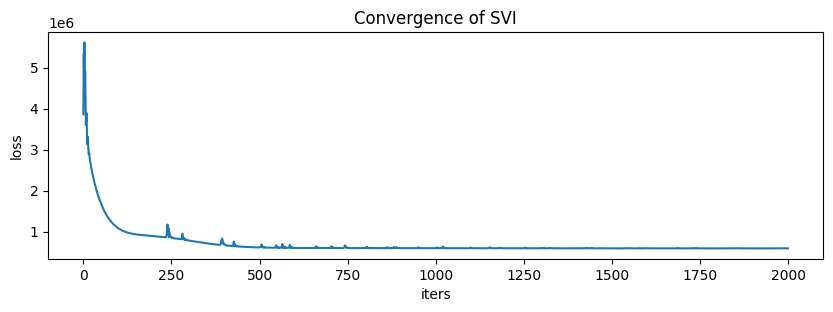

In [25]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [26]:
# replay model
guide_trace_g2 = poutine.trace(guide_g2).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)
trained_model_g2 = poutine.replay(model_g2, trace=guide_trace_g2)

# infer discrete sites and get model trace
inferred_model_g2 = infer_discrete(
    trained_model_g2, temperature=0,
    first_available_dim=-3)
trace_g2 = poutine.trace(inferred_model_g2).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)

# extract fitted parameters
nb_r_fit2 = trace_g2.nodes['expose_nb_r']['value']
betas_fit2 = trace_g2.nodes['expose_betas']['value']
beta_means_fit2 = trace_g2.nodes['expose_beta_means']['value']
beta_stds_fit2 = trace_g2.nodes['expose_beta_stds']['value']
u_fit2 = trace_g2.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


In [27]:
beta_means_fit2.shape, beta_stds_fit2.shape, betas_fit2.shape

(torch.Size([4, 5]), torch.Size([4, 5]), torch.Size([300, 5]))

In [28]:
u_fit2.shape

torch.Size([300])

### Vizualise the model output after being fit to G1/2 phase cells

300


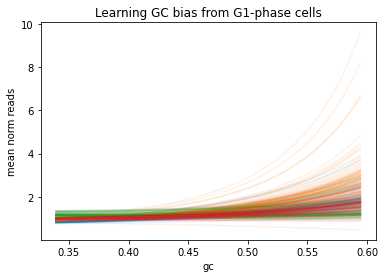

In [29]:
num_cells = cn_g1_reads.shape[1]
print(num_cells)
x = np.linspace(min(gc_profile), max(gc_profile), 101)  # gc values

# true gc betas
for i in range(num_cells):
    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit2[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    library_index = libs_g1[i]
    plt.plot(x, mean_fit, 'C{}'.format(library_index), alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.show()

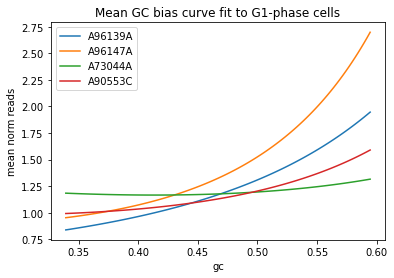

In [30]:
# plot mean gc bias curve for each library
for i, library_id in enumerate(cn_g1.library_id.unique()):
    # inferred gc betas
    p1d_fit = np.poly1d(beta_means_fit2[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'C{}'.format(i), label=library_id)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Mean GC bias curve fit to G1-phase cells')
plt.legend()
plt.show()

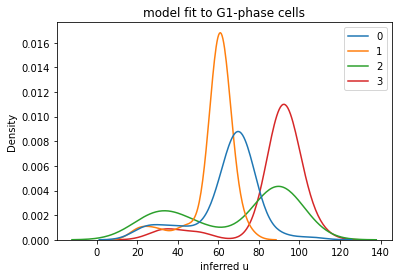

In [31]:
sns.kdeplot(x=u_fit2.detach().numpy(), hue=libs_g1.detach().numpy().astype(str))
plt.title('model fit to G1-phase cells')
plt.xlabel('inferred u');

These gc bias curves above look fairly reasonable and seem to match intuition much better than ther results I got earlier. It's possible that this is the product of having a cell-specific `u_guess` incorporated into the model based on each cell's ploidy rather than a global `u_guess` for all the cells

### See what the model output looks like when I give the model a global `u_guess` like I did within pyro_model.py

In [32]:
def model_g1(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, u_guess=70., poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/10.])))

        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [33]:
u_guess_g1 = torch.mean(cn_g1_reads) / torch.mean(cn_g1_states)
u_guess_g1

tensor(67.4860)

In [34]:
pyro.clear_param_store()

conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=2)

guide_g1 = AutoDelta(
    poutine.block(conditioned_model_g1, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g1, guide_g1, optim, loss=elbo)


In [35]:
elbo.loss(conditioned_model_g1, guide_g1, gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)

3123123.75

In [36]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

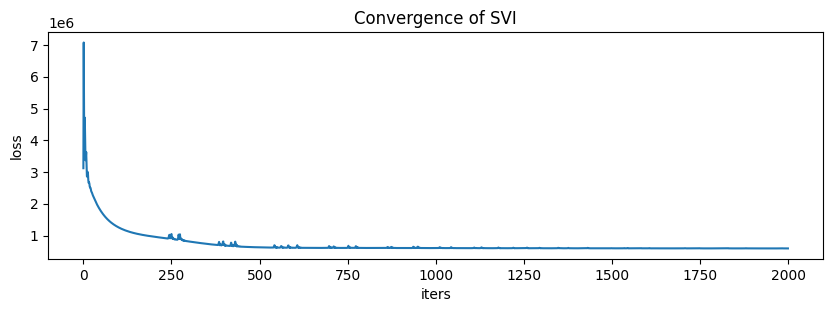

In [37]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [38]:
# replay model
guide_trace_g1 = poutine.trace(guide_g1).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)
trained_model_g1 = poutine.replay(model_g1, trace=guide_trace_g1)

# infer discrete sites and get model trace
inferred_model_g1 = infer_discrete(
    trained_model_g1, temperature=0,
    first_available_dim=-3)
trace_g1 = poutine.trace(inferred_model_g1).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)

# extract fitted parameters
nb_r_fit = trace_g1.nodes['expose_nb_r']['value']
betas_fit = trace_g1.nodes['expose_betas']['value']
beta_means_fit = trace_g1.nodes['expose_beta_means']['value']
beta_stds_fit = trace_g1.nodes['expose_beta_stds']['value']
u_fit = trace_g1.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


300


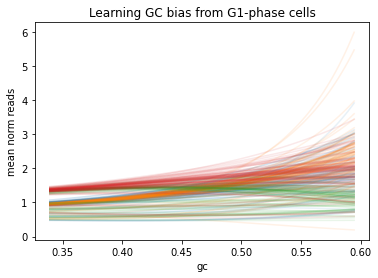

In [39]:
num_cells = cn_g1_reads.shape[1]
print(num_cells)
x = np.linspace(min(gc_profile), max(gc_profile), 101)  # gc values

# true gc betas
for i in range(num_cells):
    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    library_index = libs_g1[i]
    plt.plot(x, mean_fit, 'C{}'.format(library_index), alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.show()

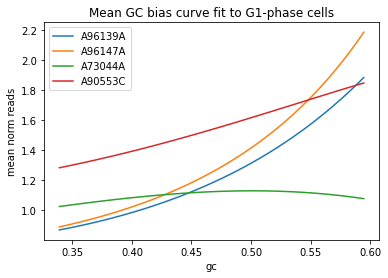

In [40]:
# plot mean gc bias curve for each library
for i, library_id in enumerate(cn_g1.library_id.unique()):
    # inferred gc betas
    p1d_fit = np.poly1d(beta_means_fit[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'C{}'.format(i), label=library_id)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Mean GC bias curve fit to G1-phase cells')
plt.legend()
plt.show()

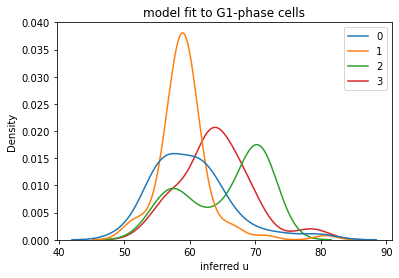

In [41]:
sns.kdeplot(x=u_fit.detach().numpy(), hue=libs_g1.detach().numpy().astype(str))
plt.title('model fit to G1-phase cells')
plt.xlabel('inferred u');

We're starting to see a separation of inferred `u` values based on library_id values. Keep in mind that both the `A96...` libraries are T-47D cells but the orange curve has lower `u` and higher absolute GC bias whereas the blue curve has higher `u` and lower absolute GC bias.

### Try to recreate the error in estimating the correct `time` in S-phase cells by using the betas learned from model_g1

In [42]:
@config_enumerate
def model_s1(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None, u_guess=70., nb_r_guess=10000., poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([nb_r_guess]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    # define cell and loci plates
    loci_plate = pyro.plate('num_loci', num_loci, dim=-2)
    cell_plate = pyro.plate('num_cells', num_cells, dim=-1)

    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with loci_plate:
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with cell_plate:

        # per cell replication time
        time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/10.])))

        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with loci_plate:

            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('expose_cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob), infer={"enumerate": "parallel"})

            # per cell per bin late or early 
            t_diff = time.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep), infer={"enumerate": "parallel"})

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [46]:
pyro.clear_param_store()

# condition gc betas of S-phase model using fitted results from G1-phase model
model_s1 = poutine.condition(
    model_s1,
    data={
        'expose_beta_means': beta_means_fit,
        'expose_beta_stds': beta_stds_fit
    })


guide_s1 = AutoDelta(poutine.block(model_s1, expose_fn=lambda msg: msg["name"].startswith("expose_")))
optim_s1 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s1 = TraceEnum_ELBO(max_plate_nesting=2)
svi_s1 = SVI(model_s1, guide_s1, optim_s1, loss=elbo_s1)

# guess the initial mean for u assuming that half the bins should be replicated
u_guess_s = torch.mean(cn_s_reads) / (1.5 * torch.mean(cn_g1_states))

In [47]:
pyro.clear_param_store()

# start inference
losses = []
for i in range(800):
    loss = svi_s1.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, u_guess=u_guess_s, nb_r_guess=nb_r_fit)

    # fancy convergence check that sees if the past 10 iterations have plateaued
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break

    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................

In [48]:
# replay model
guide_trace_s1 = poutine.trace(guide_s1).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, u_guess=u_guess_s, nb_r_guess=nb_r_fit)
trained_model_s1 = poutine.replay(model_s1, trace=guide_trace_s1)

# infer discrete sites and get model trace
inferred_model_s1 = infer_discrete(
    trained_model_s1, temperature=0,
    first_available_dim=-3)
trace_s1 = poutine.trace(inferred_model_s1).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, u_guess=u_guess_s, nb_r_guess=nb_r_fit)

# extract fitted parameters
nb_r_fit_s1 = trace_s1.nodes['expose_nb_r']['value']
u_fit_s1 = trace_s1.nodes['expose_u']['value']
rt_fit_s1 = trace_s1.nodes['expose_rt']['value']
a_fit_s1 = trace_s1.nodes['expose_a']['value']
time_fit_s1 = trace_s1.nodes['expose_time']['value']
model_rep1 = trace_s1.nodes['rep']['value']
model_cn1 = trace_s1.nodes['cn']['value']

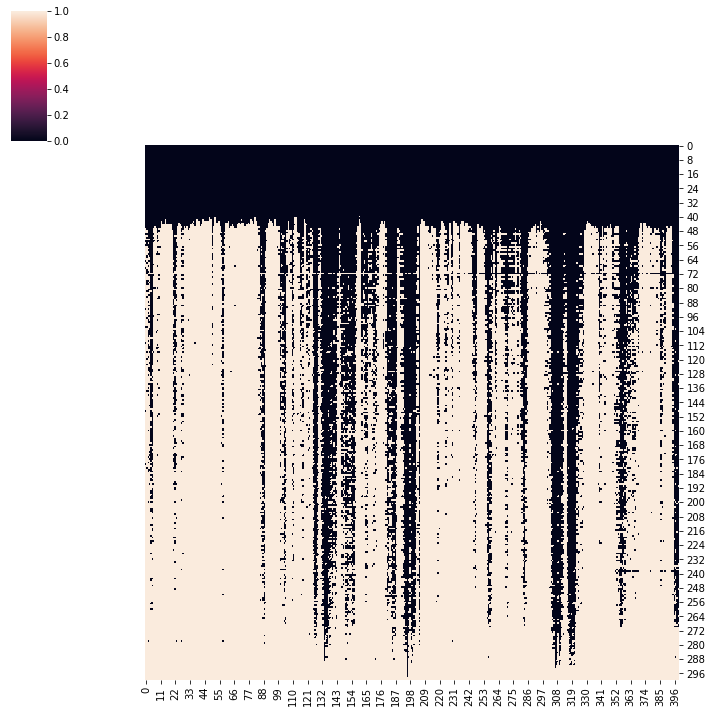

In [49]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep1.detach().numpy().astype(float).T[np.argsort(time_fit_s1.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

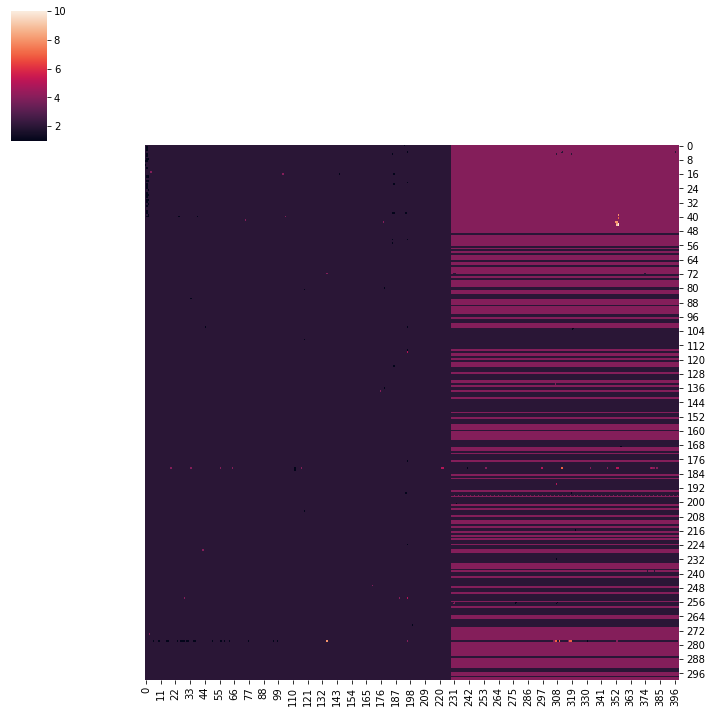

In [50]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn1.detach().numpy().astype(float).T[np.argsort(time_fit_s1.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

The following output mimics the strange results seen in the snakemake pipeline of certain cells having 0 replicated bins (which is what I wanted).

Now to see if I can find a way to remedy this error.

### Fit `model_s2` (with cell-specific guesses for `u`) using the betas learned from `model_g2`

This might solve the issue of having cells with 0 replicated bins

In [51]:
@config_enumerate
def model_s2(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, poly_degree=4, data=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None, t_init=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape
    num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.param('a', torch.tensor([10.]))
    
    # negative binomial dispersion
    nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # gc bias params
    # these should be conditioned based on fitted values for G1-phase cells
    beta_means = pyro.sample('beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('t', dist.Beta(t_alpha_prior, t_beta_prior))
        elif t_init is not None:
            t = pyro.param('t', t_init, constraint=constraints.unit_interval)
        else:
            t = pyro.sample('t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
            # u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))
            
            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

In [52]:
t_init = None # no initialization for t as of now

In [53]:
pyro.clear_param_store()

optim_s2 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s2 = TraceEnum_ELBO(max_plate_nesting=2)

conditioned_model_s2 = poutine.condition(
    model_s2,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit2,
        'beta_stds': beta_stds_fit2
    })

guide_s2 = AutoDelta(
    poutine.block(conditioned_model_s2,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi_s2 = SVI(conditioned_model_s2, guide_s2, optim_s2, loss=elbo_s2)


In [54]:
# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model_s2, guide_s2, gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'cn', 'rep'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


307820036096.0

In [55]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_s2.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

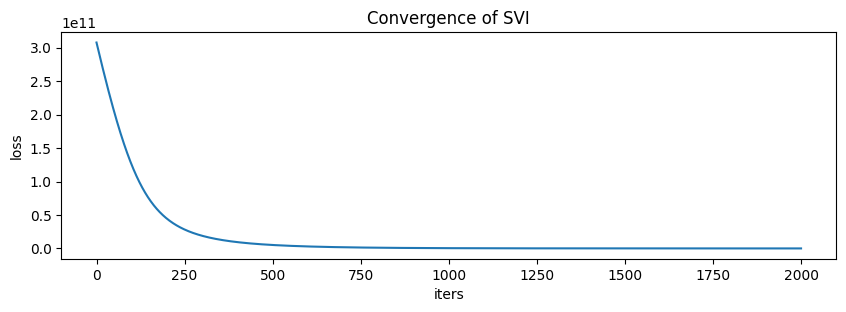

In [56]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


In [57]:
# Plot replicated state

guide_trace_s2 = poutine.trace(guide_s2).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
trained_model_s2 = poutine.replay(conditioned_model_s2, trace=guide_trace_s2)

inferred_model_s2 = infer_discrete(
    trained_model_s2, temperature=0,
    first_available_dim=-3)
trace_s2 = poutine.trace(inferred_model_s2).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)

# extract fitted parameters
nb_r_fit_s2 = trace_s2.nodes['nb_r']['value']
u_fit_s2 = trace_s2.nodes['u']['value']
rt_fit_s2 = trace_s2.nodes['rt']['value']
a_fit_s2 = trace_s2.nodes['a']['value']
time_fit_s2 = trace_s2.nodes['t']['value']
model_rep2 = trace_s2.nodes['rep']['value']
model_cn2 = trace_s2.nodes['cn']['value']

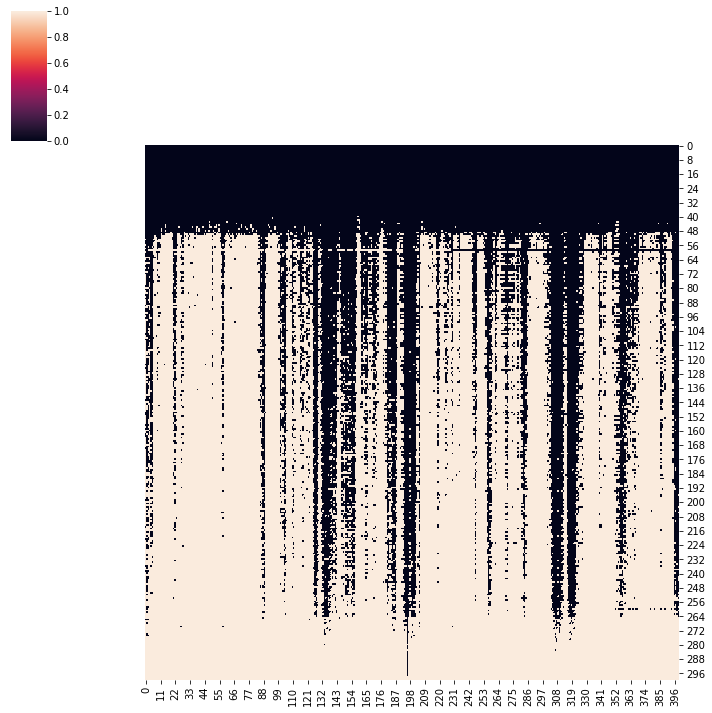

In [58]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep2.detach().numpy().astype(float).T[np.argsort(time_fit_s2.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

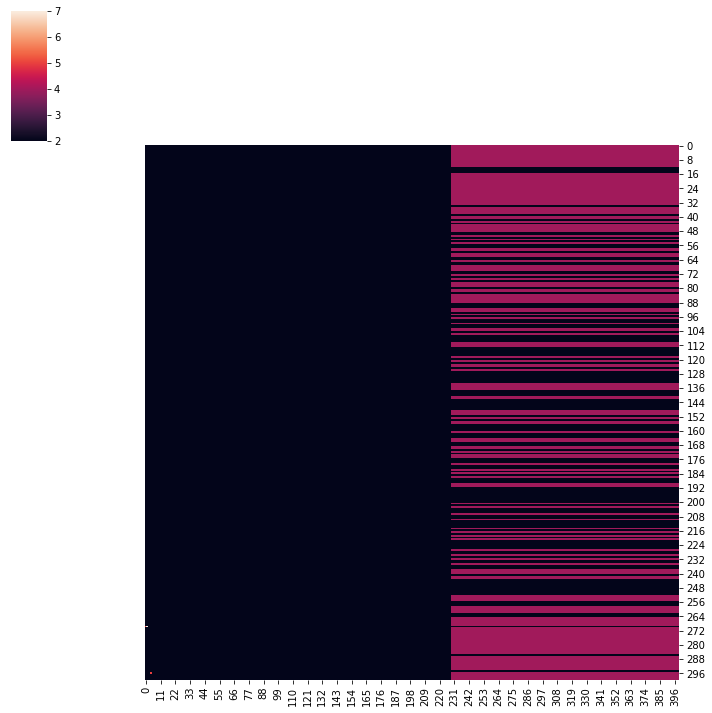

In [59]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn2.detach().numpy().astype(float).T[np.argsort(time_fit_s2.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

There are still cells with no replicated bins when the `u`s are centered around cell-specific values. However there are less of these "bad" cells than the previous version of the model that has global guesses for `u` and thus gc bias curves that differ in absolute value.

### Repeat above model except with establishing an initialization for `t` of each cell based on the binarized states

In [60]:
def manhattan_binarization(X, MEAN_GAP_THRESH=0.7, EARLY_S_SKEW_THRESH=0.2, LATE_S_SKEW_THRESH=-0.2):
    # center and scale the data
    X = (X - np.mean(X)) / np.std(X)
    
    # fit a 2-state GMM to the data
    gm = GaussianMixture(n_components=2, random_state=0)
    states = gm.fit_predict(X)
    
    # use GMM means to assign binary values for thresholding
    mean_0 = gm.means_[0][0]
    mean_1 = gm.means_[1][0]

    # find the distance between the two means for each state
    mean_gap = abs(mean_0 - mean_1)

    # assume means denote binary values
    binary_0 = min(mean_0, mean_1)
    binary_1 = max(mean_0, mean_1)
    
    X = X.flatten()
    
    # use skew to define the binary values if means are close together
    if mean_gap < MEAN_GAP_THRESH:
        cell_skew = skew(X)
        print('cell_skew', cell_skew)
        # positive skew indicates early S-phase
        if cell_skew > EARLY_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 50)
            binary_1 = np.percentile(X, 95)
        # negative skew indicates late S-phase
        elif cell_skew < LATE_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 5)
            binary_1 = np.percentile(X, 50)
        # assume mid-S when skew is neutral
        else:
            binary_0 = np.percentile(X, 25)
            binary_1 = np.percentile(X, 75)

    # now that binary values are selected, I must compute the Manhattan distance
    # between binarized data and X for 100 different thresholds
    threshs = np.linspace(binary_0, binary_1, 100)
    lowest_dist = np.inf
    best_t = None
    manhattan_dists = []
    for t in threshs:
        # set values to binary_1 when above t, to binary_0 when below t
        B = np.where(X>t, binary_1, binary_0)
        # compute Manhattan distance between two vectors
        dist = cityblock(X, B)
        manhattan_dists.append(dist)
        if dist < lowest_dist:
            lowest_dist = dist
            best_t = t

    # binarize X based on the best threshold
    cell_rt = np.where(X>best_t, 1, 0)
    # compute fraction of replicated bins (cell's time within s-phase)
    frac_rt = sum(cell_rt) / len(cell_rt)
    
    return cell_rt, frac_rt



In [61]:
reads_norm_by_cn = cn_s_reads / torch.argmax(cn_prior, dim=2)

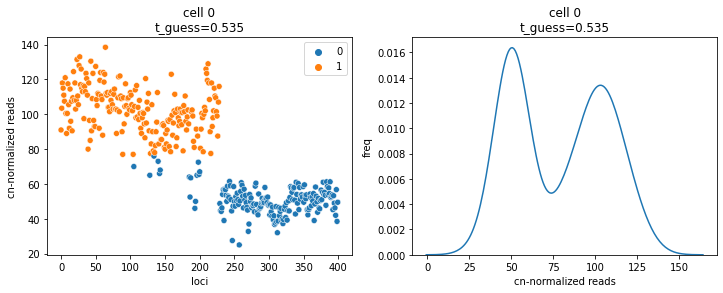

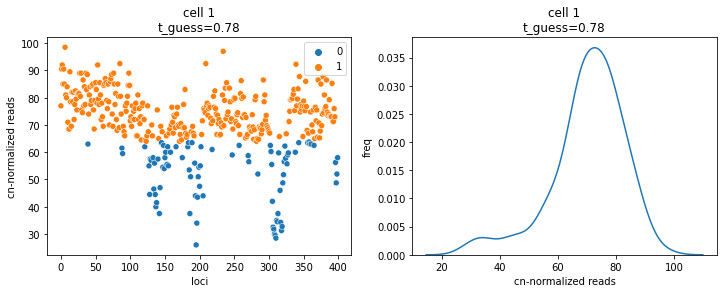

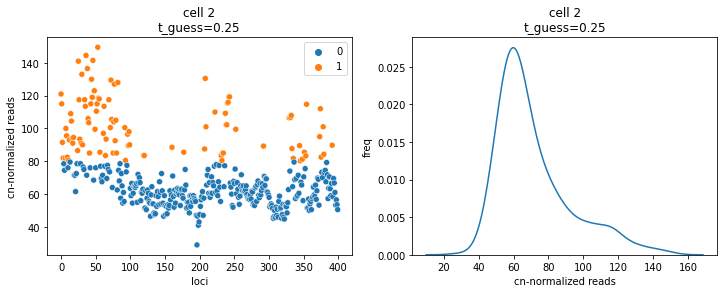

In [62]:
t_init = torch.zeros(num_cells)
t_alpha_prior = torch.zeros(num_cells)
t_beta_prior = torch.zeros(num_cells)
gamma = 6
for i in range(num_cells):
    cell_profile = reads_norm_by_cn[:, i]
    
    X = cell_profile.numpy().reshape(-1, 1)
    y_pred2, t_guess = manhattan_binarization(X)
    
    t_init[i] = t_guess
    
    alpha = t_guess * gamma
    beta = gamma - alpha
    t_alpha_prior[i] = alpha
    t_beta_prior[i] = beta
    
    if i < 3:

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        sns.scatterplot(x=torch.arange(0, num_loci), y=cell_profile, hue=y_pred2, ax=ax[0])
        ax[0].set_xlabel('loci')
        ax[0].set_ylabel('cn-normalized reads')
        ax[0].set_title('cell {}\nt_guess={}'.format(i, round(t_guess, 3)))

        sns.kdeplot(x=cell_profile, ax=ax[1])
        ax[1].set_xlabel('cn-normalized reads')
        ax[1].set_ylabel('freq')
        ax[1].set_title('cell {}\nt_guess={}'.format(i, round(t_guess, 3)))

        plt.show()


In [63]:
pyro.clear_param_store()

optim_s3 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s3 = TraceEnum_ELBO(max_plate_nesting=2)

conditioned_model_s3 = poutine.condition(
    model_s2,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit2,
        'beta_stds': beta_stds_fit2
    })

guide_s3 = AutoDelta(
    poutine.block(conditioned_model_s3,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi_s3 = SVI(conditioned_model_s3, guide_s3, optim_s3, loss=elbo_s3)


In [64]:
# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model_s3, guide_s3, gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'cn', 'rep'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


307821838336.0

In [65]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_s3.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

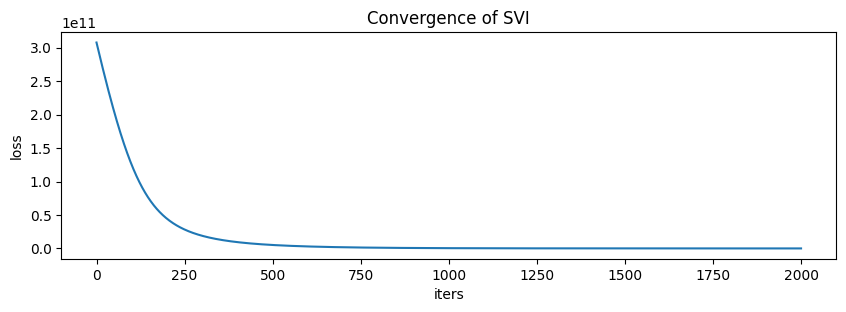

In [66]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


In [67]:
# Plot replicated state

guide_trace_s3 = poutine.trace(guide_s3).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)
trained_model_s3 = poutine.replay(conditioned_model_s3, trace=guide_trace_s3)

inferred_model_s3 = infer_discrete(
    trained_model_s3, temperature=0,
    first_available_dim=-3)
trace_s3 = poutine.trace(inferred_model_s3).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)

# extract fitted parameters
nb_r_fit_s3 = trace_s3.nodes['nb_r']['value']
u_fit_s3 = trace_s3.nodes['u']['value']
rt_fit_s3 = trace_s3.nodes['rt']['value']
a_fit_s3 = trace_s3.nodes['a']['value']
time_fit_s3 = trace_s3.nodes['t']['value']
model_rep3 = trace_s3.nodes['rep']['value']
model_cn3 = trace_s3.nodes['cn']['value']

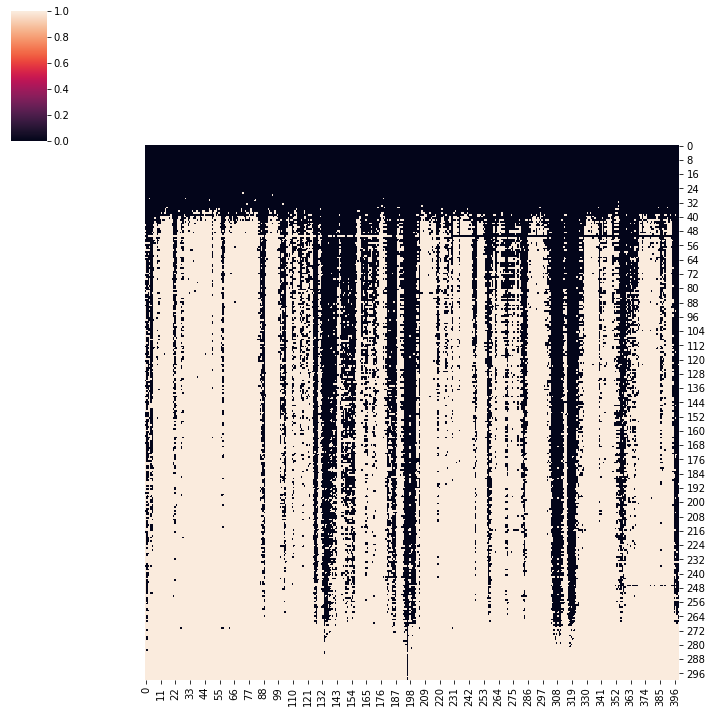

In [68]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep3.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

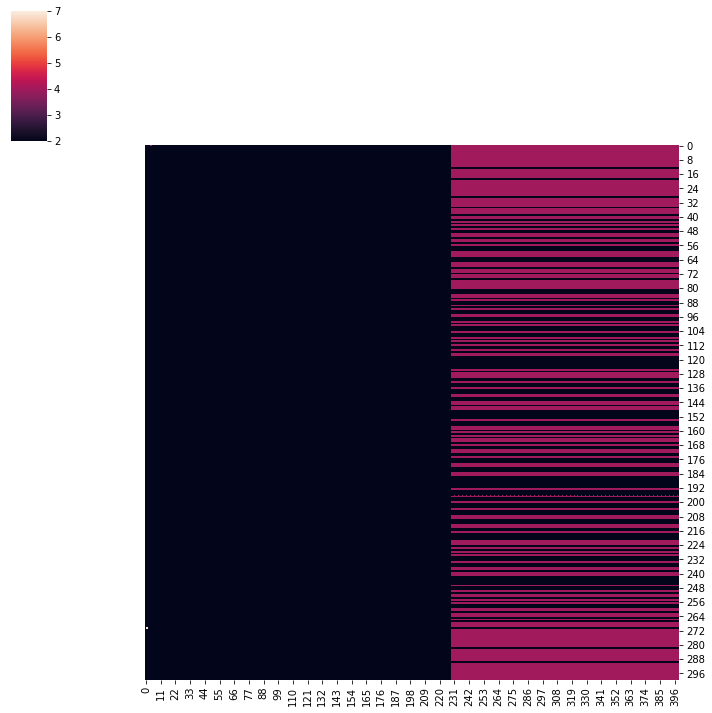

In [69]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn3.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

### Compute replication states with manhattan binarization methods

This can serve as a quasi-ground truth

In [70]:
reads_norm_by_cn.shape

torch.Size([400, 300])

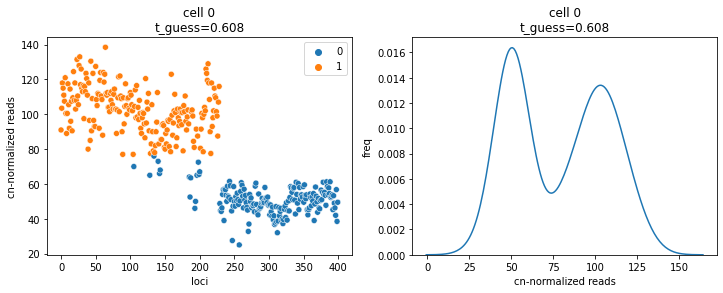

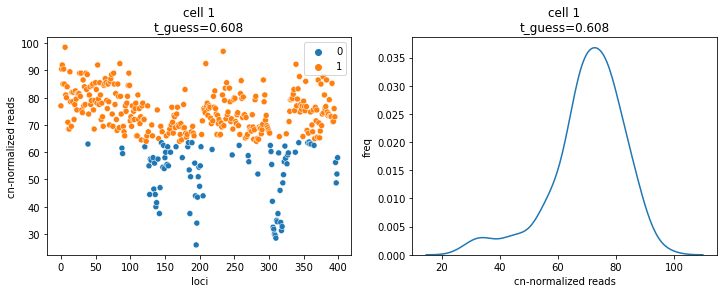

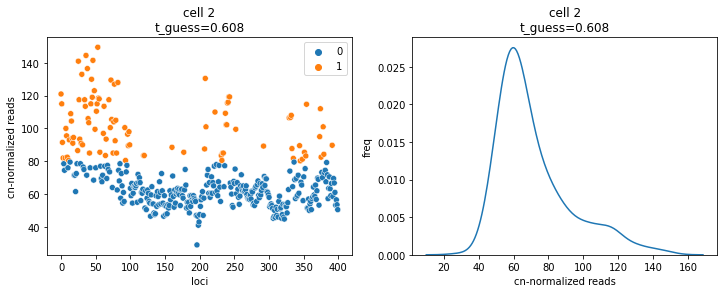

In [71]:
binary_rep_states = np.zeros((num_loci, num_cells))
frac_reps = np.zeros((num_cells))
for i in range(num_cells):
    cell_profile = reads_norm_by_cn[:, i]
    X = cell_profile.numpy().reshape(-1, 1)
    y_pred2, frac = manhattan_binarization(X)
    
    binary_rep_states[:, i] = y_pred2
    frac_reps[i] = frac
    
    if i < 3:

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        sns.scatterplot(x=torch.arange(0, num_loci), y=cell_profile, hue=y_pred2, ax=ax[0])
        ax[0].set_xlabel('loci')
        ax[0].set_ylabel('cn-normalized reads')
        ax[0].set_title('cell {}\nt_guess={}'.format(i, round(t_guess, 3)))

        sns.kdeplot(x=cell_profile, ax=ax[1])
        ax[1].set_xlabel('cn-normalized reads')
        ax[1].set_ylabel('freq')
        ax[1].set_title('cell {}\nt_guess={}'.format(i, round(t_guess, 3)))

        plt.show()

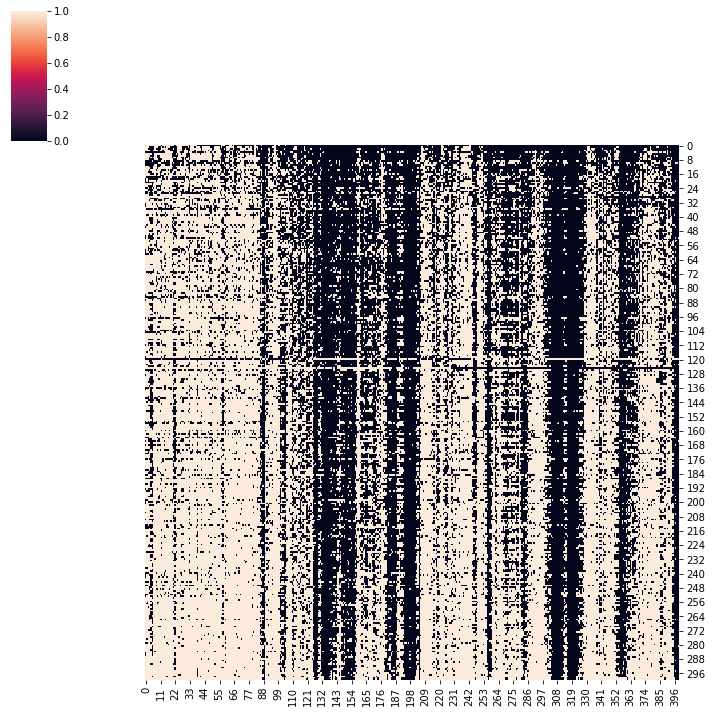

In [72]:
# plot replication states sorted by frac_rep of the binary states
sns.clustermap(binary_rep_states.astype(float).T[np.argsort(frac_reps), :], col_cluster=False, row_cluster=False)
plt.show()

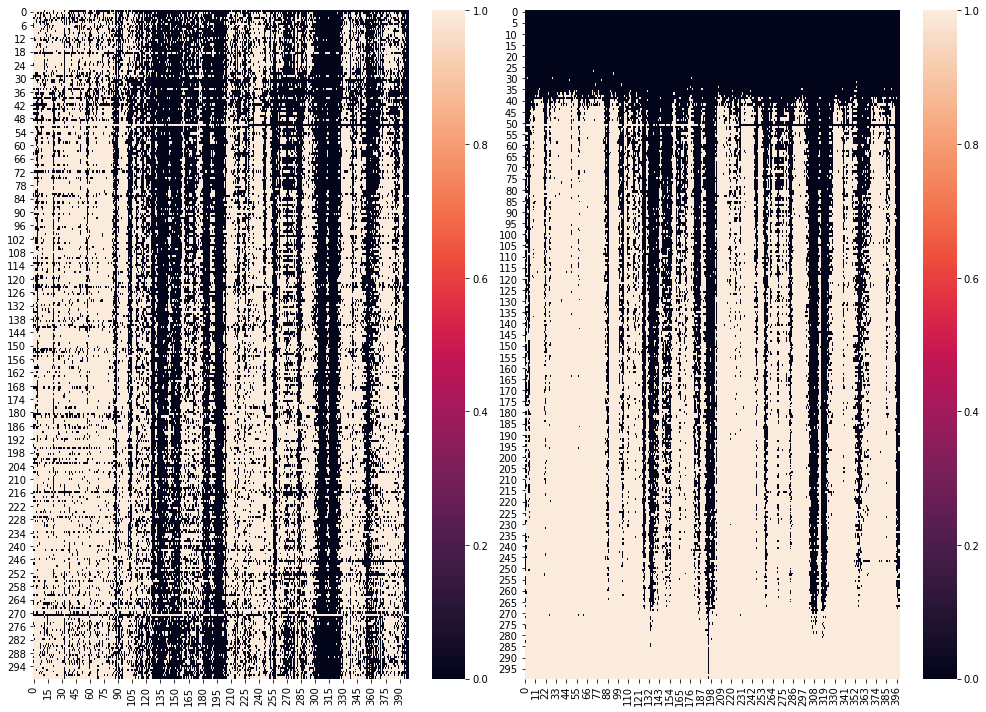

In [73]:
# plot replication states sorted by frac_rep sorted by the model's inferred t
fig, ax = plt.subplots(1, 2, figsize=(14, 10), tight_layout=True)
ax = ax.flatten()

sns.heatmap(binary_rep_states.astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], 
            ax=ax[0])

sns.heatmap(model_rep3.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], 
            ax=ax[1])

plt.show()

### Plot the different model results to see if it's the same "bad" cells in every model flavor

Sort all heatmaps by `model_s3` results

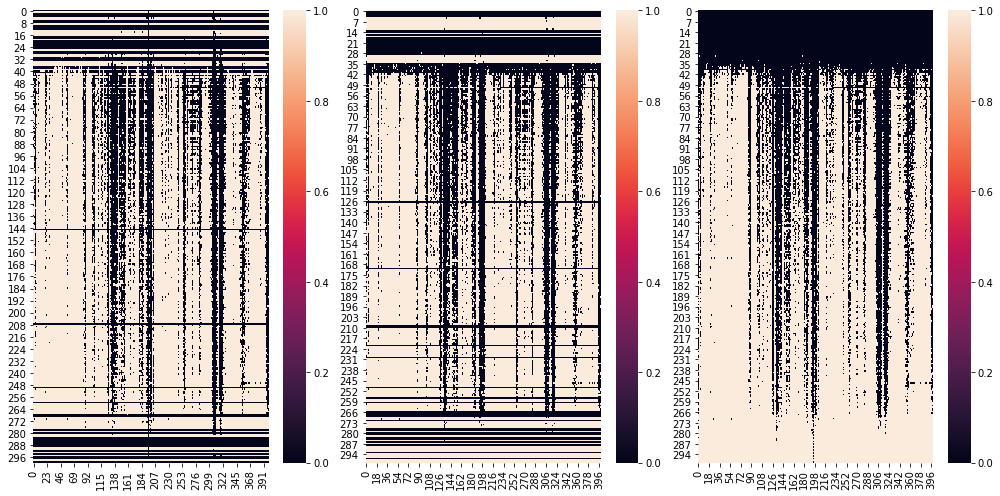

In [74]:
# plot replication states sorted by frac_rep sorted by the model's inferred t
fig, ax = plt.subplots(1, 3, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

sns.heatmap(model_rep1.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], 
            ax=ax[0])

sns.heatmap(model_rep2.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], 
            ax=ax[1])

sns.heatmap(model_rep3.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], 
            ax=ax[2])

plt.show()

It seems like its a unique set of cells in each model run that wind up with extreme `frac_rep` values; however it doesn't seem to be totally random. Most of the horizontal stripes on the left two heatmaps are in cells with extreme `frac_rep` values in model_s3 which means these might be poor model fits.

### Try changing the rules of how gc bias is calculated

In [75]:
torch.sum(cn_s_reads, dim=0)

tensor([79796., 79795., 79792., 79802., 79794., 79800., 79808., 79800., 79789.,
        79800., 79792., 79809., 79794., 79804., 79795., 79804., 79795., 79800.,
        79790., 79797., 79817., 79806., 79799., 79794., 79791., 79788., 79796.,
        79801., 79810., 79792., 79796., 79793., 79799., 79790., 79806., 79791.,
        79798., 79805., 79786., 79795., 79802., 79796., 79808., 79805., 79816.,
        79802., 79797., 79803., 79792., 79794., 79789., 79801., 79803., 79803.,
        79794., 79801., 79787., 79803., 79801., 79799., 79815., 79802., 79810.,
        79802., 79808., 79797., 79807., 79787., 79798., 79801., 79803., 79796.,
        79806., 79800., 79799., 79809., 79792., 79791., 79798., 79802., 79806.,
        79796., 79813., 79795., 79797., 79799., 79806., 79797., 79809., 79799.,
        79803., 79808., 79796., 79802., 79801., 79794., 79804., 79802., 79795.,
        79797., 79804., 79801., 79799., 79802., 79806., 79796., 79816., 79798.,
        79797., 79802., 79806., 79806., 

In [94]:
@config_enumerate
def model_g3(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        # u should be inversely related to cn, positively related to reads
        if (data is not None) and (cn is not None):
            cell_ploidies = torch.mean(cn.type(torch.float32), dim=0)
            u = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
#         else:
#             u_guess = torch.tensor([70.])
#             u_stdev = u_guess / 10.
#             u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))
        
        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            # gc_rate = gc_rate / torch.mean(gc_rate)
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)
            
#             # normalize expected_reads so that each cell has 1million reads
#             if data is not None:
#                 expected_reads = expected_reads * torch.sum(data, dim=0) / torch.sum(expected_reads, dim=0)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [95]:

pyro.clear_param_store()

conditioned_model_g3 = poutine.condition(
    model_g3,
    data={
    })

optim_g3 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_g3 = Trace_ELBO(max_plate_nesting=2)

guide_g3 = AutoDelta(
    poutine.block(conditioned_model_g3, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi_g3 = SVI(conditioned_model_g3, guide_g3, optim_g3, loss=elbo_g3)


In [96]:
elbo_g3.loss(conditioned_model_g3, guide_g3, gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)

2479050.5

In [97]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_g3.step(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

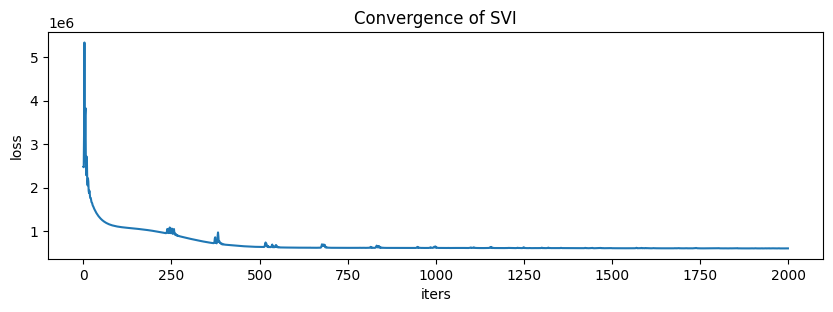

In [98]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [100]:
# replay model
guide_trace_g3 = poutine.trace(guide_g3).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)
trained_model_g3 = poutine.replay(model_g3, trace=guide_trace_g3)

# infer discrete sites and get model trace
inferred_model_g3 = infer_discrete(
    trained_model_g3, temperature=0,
    first_available_dim=-3)
trace_g3 = poutine.trace(inferred_model_g3).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)

# extract fitted parameters
nb_r_fit3 = trace_g3.nodes['expose_nb_r']['value']
betas_fit3 = trace_g3.nodes['expose_betas']['value']
beta_means_fit3 = trace_g3.nodes['expose_beta_means']['value']
beta_stds_fit3 = trace_g3.nodes['expose_beta_stds']['value']
#u_fit3 = trace_g3.nodes['expose_u']['value']

300


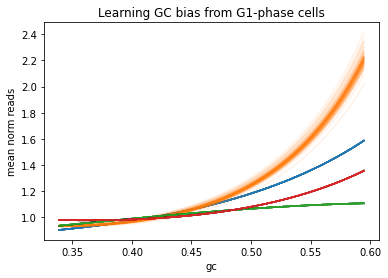

In [101]:
num_cells = cn_g1_reads.shape[1]
print(num_cells)
x = np.linspace(min(gc_profile), max(gc_profile), 101)  # gc values

# true gc betas
for i in range(num_cells):
    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit3[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    library_index = libs_g1[i]
    plt.plot(x, mean_fit, 'C{}'.format(library_index), alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.show()

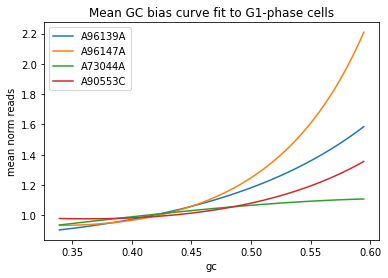

In [102]:
# plot mean gc bias curve for each library
for i, library_id in enumerate(cn_g1.library_id.unique()):
    # inferred gc betas
    p1d_fit = np.poly1d(beta_means_fit3[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'C{}'.format(i), label=library_id)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Mean GC bias curve fit to G1-phase cells')
plt.legend()
plt.show()

In [103]:
# sns.kdeplot(x=u_fit3.detach().numpy(), hue=libs_g1.detach().numpy().astype(str))
# plt.title('model fit to G1-phase cells')
# plt.xlabel('inferred u');

In [104]:
@config_enumerate
def model_s4(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, poly_degree=4, data=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None, t_init=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape
    num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.param('a', torch.tensor([10.]))
    
    # negative binomial dispersion
    nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # gc bias params
    # these should be conditioned based on fitted values for G1-phase cells
    beta_means = pyro.sample('beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('t', dist.Beta(t_alpha_prior, t_beta_prior))
        elif t_init is not None:
            t = pyro.param('t', t_init, constraint=constraints.unit_interval)
        else:
            t = pyro.sample('t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
            # u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))
            
            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)
            
            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

In [105]:
pyro.clear_param_store()

optim_s4 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s4 = TraceEnum_ELBO(max_plate_nesting=2)

conditioned_model_s4 = poutine.condition(
    model_s4,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit3,
        'beta_stds': beta_stds_fit3
    })

guide_s4 = AutoDelta(
    poutine.block(conditioned_model_s4,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi_s4 = SVI(conditioned_model_s4, guide_s4, optim_s4, loss=elbo_s4)


In [106]:
t_init = None

In [107]:
# Calculate initial loss

pyro.clear_param_store()

elbo_s4.loss(conditioned_model_s4, guide_s4, gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)


307766263808.0

In [108]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_s4.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

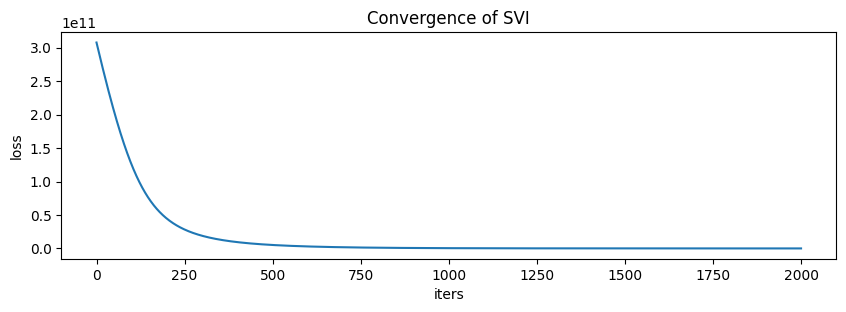

In [109]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


In [110]:
# Plot replicated state

guide_trace_s4 = poutine.trace(guide_s4).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
trained_model_s4 = poutine.replay(conditioned_model_s4, trace=guide_trace_s4)

inferred_model_s4 = infer_discrete(
    trained_model_s4, temperature=0,
    first_available_dim=-3)
trace_s4 = poutine.trace(inferred_model_s4).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)

# extract fitted parameters
nb_r_fit_s4 = trace_s4.nodes['nb_r']['value']
u_fit_s4 = trace_s4.nodes['u']['value']
rt_fit_s4 = trace_s4.nodes['rt']['value']
a_fit_s4 = trace_s4.nodes['a']['value']
time_fit_s4 = trace_s4.nodes['t']['value']
model_rep4 = trace_s4.nodes['rep']['value']
model_cn4 = trace_s4.nodes['cn']['value']

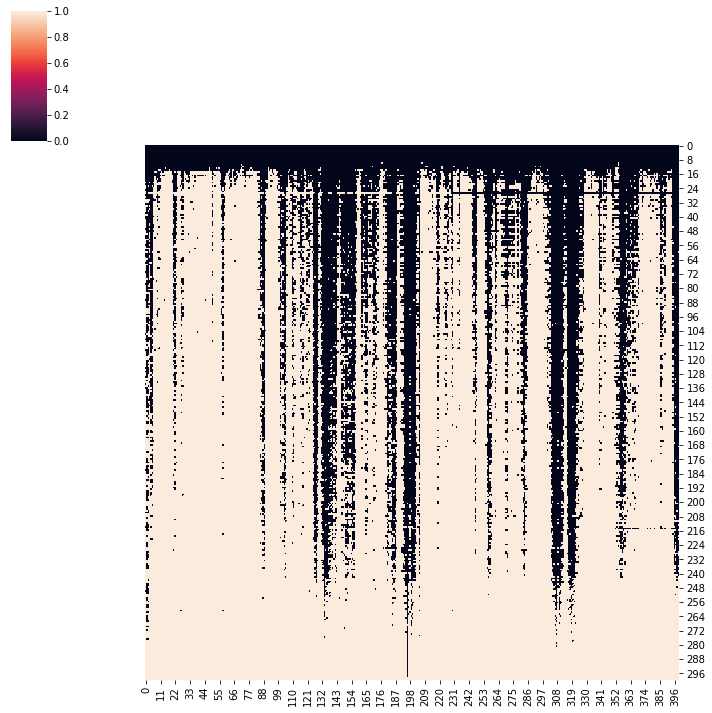

In [111]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep4.detach().numpy().astype(float).T[np.argsort(time_fit_s4.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

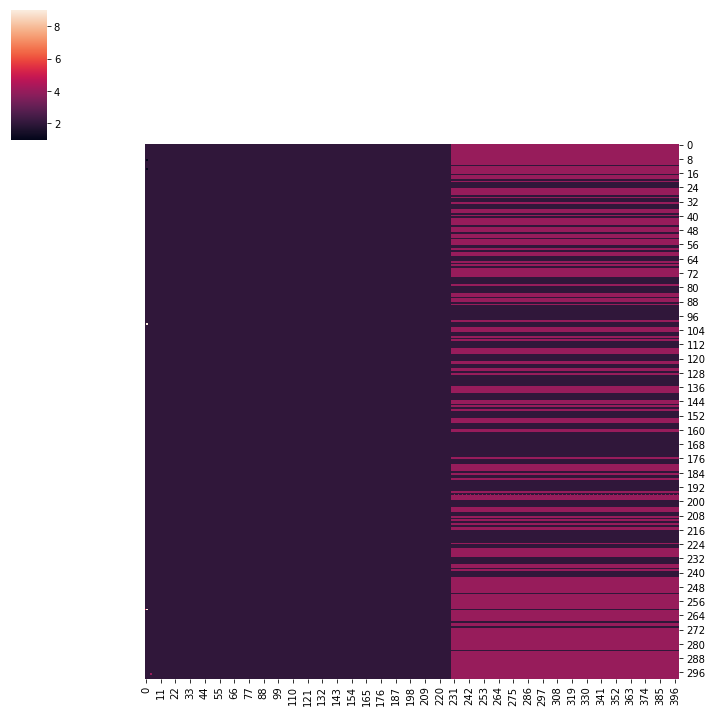

In [112]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn4.detach().numpy().astype(float).T[np.argsort(time_fit_s4.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

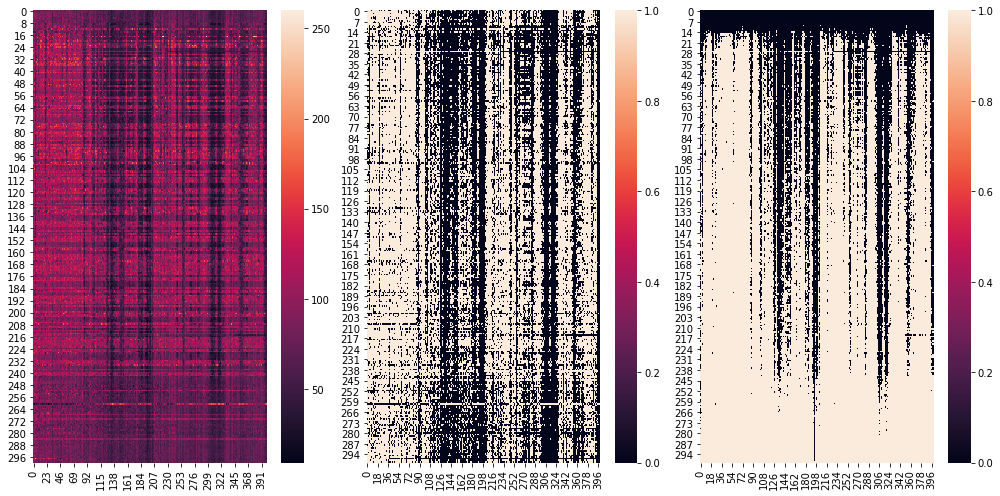

In [115]:
# plot replication states sorted by frac_rep sorted by the model's inferred t
fig, ax = plt.subplots(1, 3, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

sns.heatmap(reads_norm_by_cn.numpy().astype(float).T[np.argsort(time_fit_s4.detach().numpy()), :], 
            ax=ax[0])

sns.heatmap(binary_rep_states.astype(float).T[np.argsort(time_fit_s4.detach().numpy()), :], 
            ax=ax[1])

sns.heatmap(model_rep4.detach().numpy().astype(float).T[np.argsort(time_fit_s4.detach().numpy()), :], 
            ax=ax[2])

plt.show()

### Try to see if the cells with extreme `frac_rep` values are truly in S-phase for the latest version of the model

In [117]:
cn_s_reads_df.head()

cell_id      SA1044-A96139A-R03-C36  SA1044-A96139A-R04-C24  \
chr start                                                     
1   1500001              182.114418              154.078886   
    2000001              207.081717              181.724156   
    3000001              236.087845              184.624010   
    4000001              230.947518              170.124742   
    4500001              222.502696              181.724156   

cell_id      SA1044-A96139A-R04-C26  SA1044-A96139A-R05-C23  \
chr start                                                     
1   1500001              242.345038              170.600922   
    2000001              230.881223              173.250005   
    3000001              183.191755              214.399089   
    4000001              164.620376              195.502299   
    4500001              157.054258              141.990830   

cell_id      SA1044-A96139A-R05-C28  SA1044-A96139A-R06-C24  \
chr start                                                     
1   1500001              210.123338              170.292442   
    2000001              235.614904              170.710851   
    3000001              216.678312              173.012100   
    4000001              159.868536              173.221304   
    4500001              124.726592              166.735966   

cell_id      SA1044-A96139A-R07-C23  SA1044-A96139A-R07-C24  \
chr start                                                     
1   1500001              154.327026              141.395106   
    2000001              183.081354              154.684938   
    3000001              174.709841              193.682972   
    4000001              155.418962              165.578244   
    4500001              189.632973              111.547449   

cell_id      SA1044-A96139A-R08-C30  SA1044-A96139A-R09-C29  ...  \
chr start                                                    ...   
1   1500001              186.052468              174.651930  ...   
    2000001              170.136475              204.114951  ...   
    3000001              228.129231              221.124531  ...   
    4000001              195.748418              140.936514  ...   
    4500001               97.325381              108.132325  ...   

cell_id      SA928-A90553C-R64-C44  SA928-A90553C-R64-C51  \
chr start                                                   
1   1500001             177.697372             189.766434   
    2000001             233.177547             208.444233   
    3000001             215.488215             251.029614   
    4000001             243.630333             227.869143   
    4500001             146.339012             268.960300   

cell_id      SA928-A90553C-R65-C41  SA928-A90553C-R65-C48  \
chr start                                                   
1   1500001             180.356581             259.579623   
    2000001             206.943010             231.113973   
    3000001             211.254323             174.860425   
    4000001             248.619033             166.727382   
    4500001             163.829883             168.760643   

cell_id      SA928-A90553C-R65-C50  SA928-A90553C-R66-C41  \
chr start                                                   
1   1500001             218.089908             228.602717   
    2000001             236.143708             214.913932   
    3000001             178.371547             154.683276   
    4000001             147.319011             147.838883   
    4500001             147.319011             145.101126   

cell_id      SA928-A90553C-R66-C54  SA928-A90553C-R67-C44  \
chr start                                                   
1   1500001             220.251983             317.082460   
    2000001             194.120392             179.013521   
    3000001             231.451237             233.288897   
    4000001             322.289625             227.575700   
    4500001             196.609115             162.826128   

cell_id      SA928-A90553C-R67-C47  SA928-A

In [124]:
frac_rep4 = model_rep4.sum(dim=0) / num_loci
frac_rep4

tensor([0.4975, 0.9450, 0.0050, 0.8500, 0.4950, 0.9975, 1.0000, 0.8075, 0.7525,
        0.5550, 0.9975, 0.9975, 0.7850, 0.2750, 0.5750, 0.7625, 0.8400, 0.5975,
        0.4525, 0.9975, 0.9950, 0.5525, 0.7875, 0.9975, 0.1275, 0.6725, 0.6550,
        0.9125, 0.8250, 0.6725, 0.5800, 0.7475, 0.9925, 0.9725, 0.9950, 0.6825,
        0.6575, 0.7675, 0.9975, 0.0000, 0.9375, 0.9950, 0.7075, 0.9975, 0.6025,
        0.0000, 0.9925, 0.9975, 0.8850, 0.0075, 0.8925, 0.6500, 0.9925, 0.5650,
        0.7175, 0.9975, 0.8200, 0.0000, 0.9775, 0.8575, 0.5425, 0.9975, 0.6650,
        0.8525, 0.7300, 0.9975, 0.6600, 0.9025, 0.5850, 0.7275, 0.9925, 0.9875,
        0.9850, 0.8450, 0.7800, 0.9375, 0.9725, 0.7800, 0.9975, 0.9675, 0.9950,
        0.0000, 0.9975, 0.9975, 0.5325, 0.8850, 0.8200, 0.7625, 0.8575, 0.6775,
        0.9975, 0.8450, 0.7725, 0.9675, 0.6350, 0.8425, 0.6150, 0.7500, 0.9975,
        0.7175, 0.9825, 0.0000, 0.9975, 0.5800, 0.0325, 0.5850, 0.6775, 0.8100,
        0.5850, 0.3175, 0.8850, 0.7175, 

In [126]:
bad_cell_mask = np.where(frac_rep4.numpy() > 0.9, 1, 0) + np.where(frac_rep4.numpy() < 0.1, 1, 0)
bad_cell_mask

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [130]:
bad_cn_s_reads_df = cn_s_reads_df.iloc[:, bad_cell_mask==1]
bad_cn_s_reads_df.shape

(400, 77)

In [132]:
bad_cn_s = cn_s.loc[cn_s['cell_id'].isin(bad_cn_s_reads_df.columns)]
bad_cn_s.cell_id.unique().shape

(77,)

In [133]:
bad_cn_s.head()

cell_id chr    start      end        gc  reads  state  \
400  SA1044-A96139A-R04-C24   1  1500001  2000000  0.539498  797.0    2.0   
401  SA1044-A96139A-R04-C24   1  2000001  2500000  0.594508  940.0    2.0   
402  SA1044-A96139A-R04-C24   1  3000001  3500000  0.584572  955.0    2.0   
403  SA1044-A96139A-R04-C24   1  4000001  4500000  0.482574  880.0    2.0   
404  SA1044-A96139A-R04-C24   1  4500001  5000000  0.481828  940.0    2.0   

         copy         rpm sample_id library_id cell_cycle_state  quality  \
400  1.860787  156.619256    SA1044    A96139A                S    0.988   
401  2.687115  184.720328    SA1044    A96139A                S    0.988   
402  2.593333  187.667992    SA1044    A96139A                S    0.988   
403  1.959981  172.929668    SA1044    A96139A                S    0.988   
404  2.094259  184.720328    SA1044    A96139A                S    0.988   

     total_mapped_reads_hmmcopy  breakpoints        rpm2 clone_id  
400                   5193641.0        131.0  154.078886   SA1044  
401                   5193641.0        131.0  181.724156   SA1044  
402                   5193641.0        131.0  184.624010   SA1044  
403                   5193641.0        131.0  170.124742   SA1044  
404                   5193641.0        131.0  181.724156   SA1044

In [134]:
bad_cn_s['rpm2_state_norm'] = bad_cn_s['rpm2'] / bad_cn_s['state']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
good_cn_s = cn_s.loc[~cn_s['cell_id'].isin(bad_cn_s_reads_df.columns)]
good_cn_s['rpm2_state_norm'] = good_cn_s['rpm2'] / good_cn_s['state']
good_cn_s.cell_id.unique().shape

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(223,)

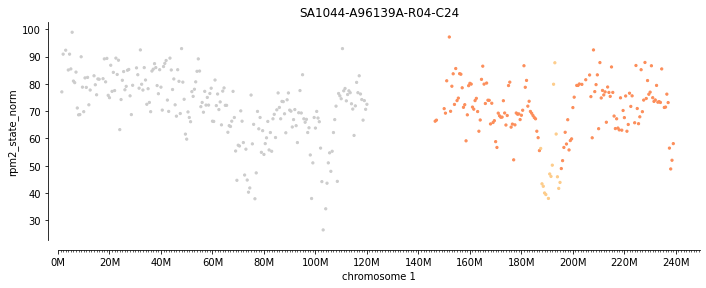

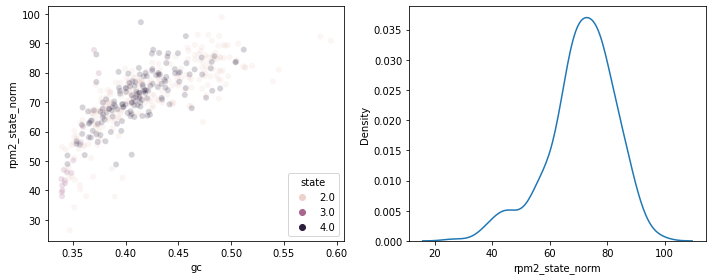

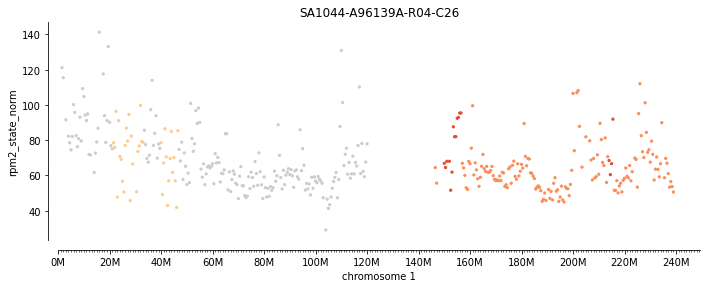

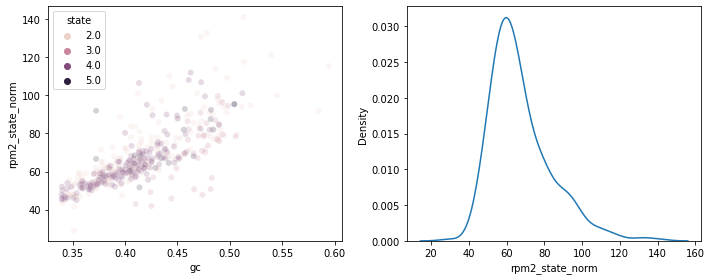

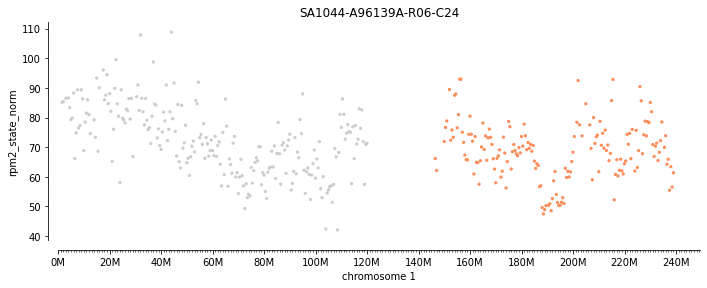

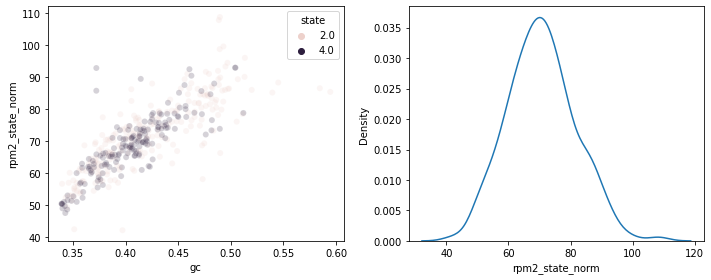

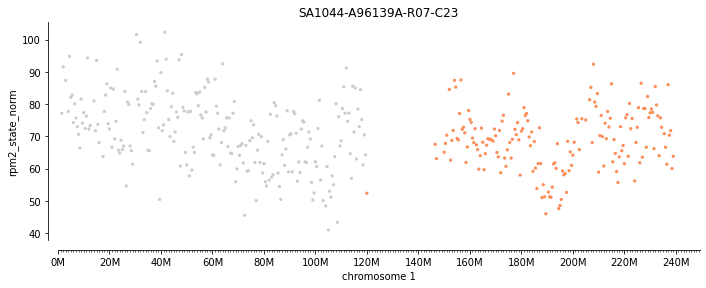

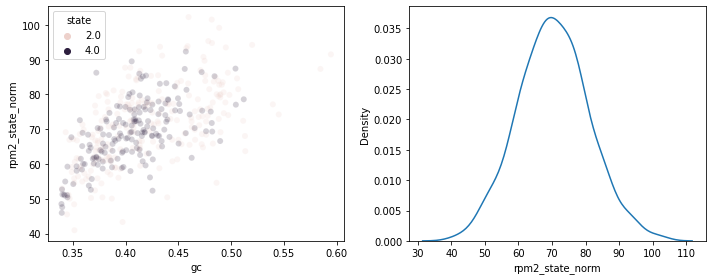

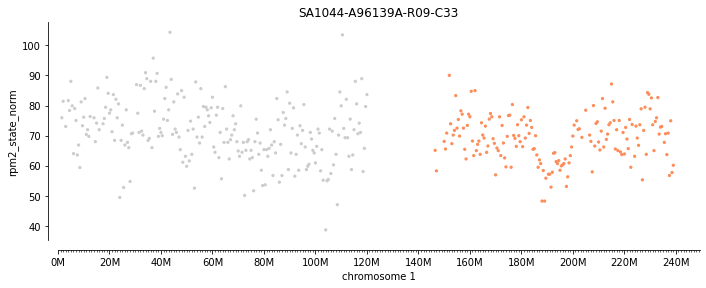

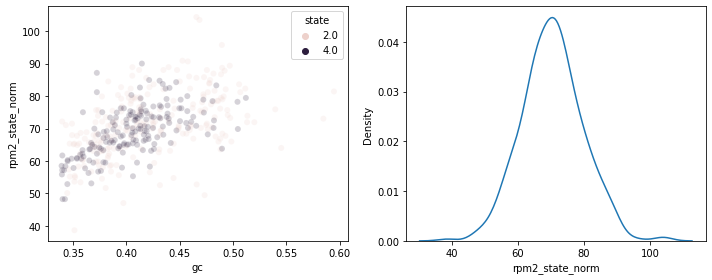

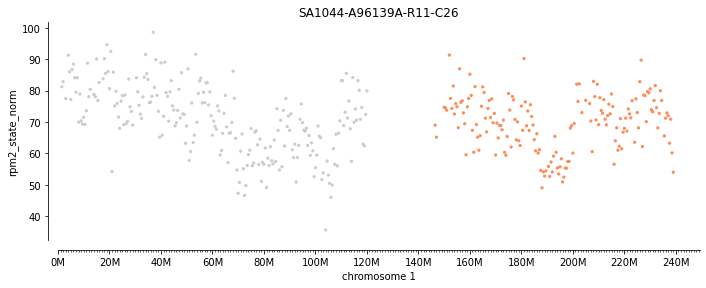

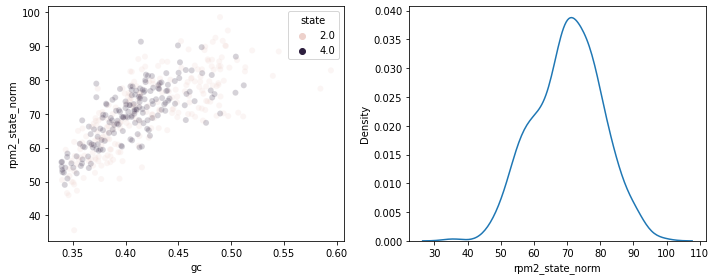

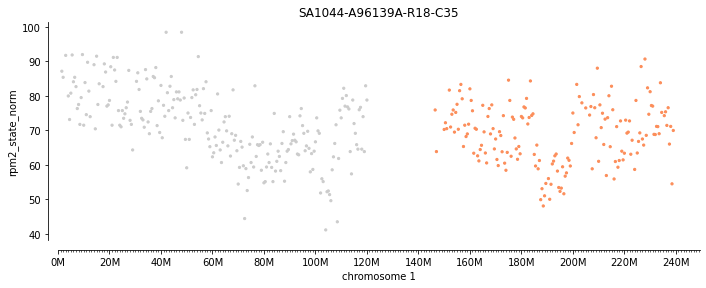

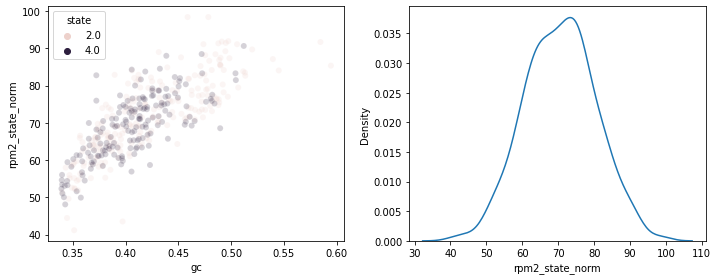

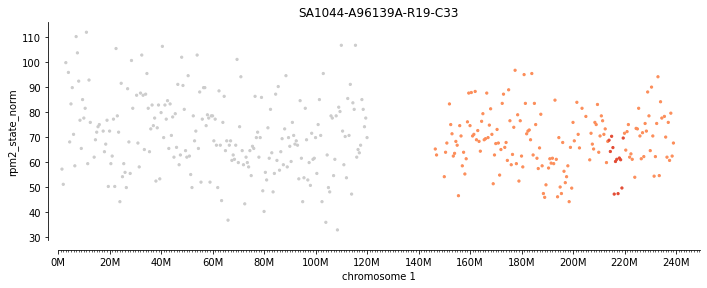

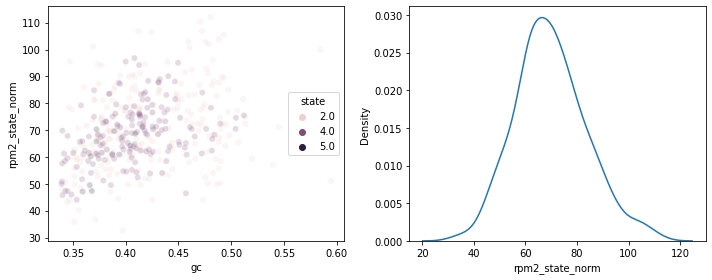

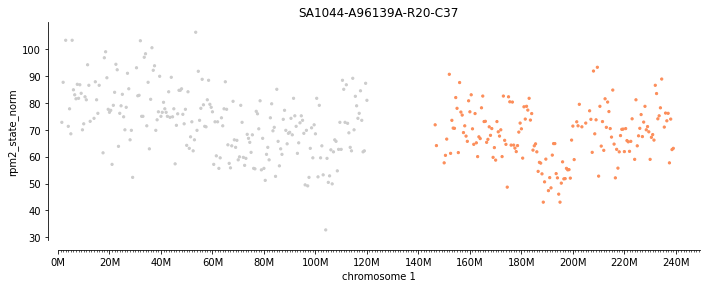

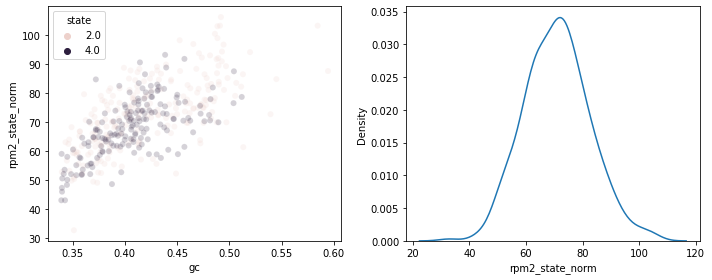

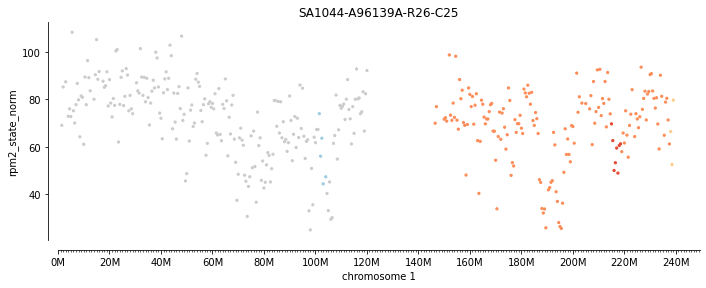

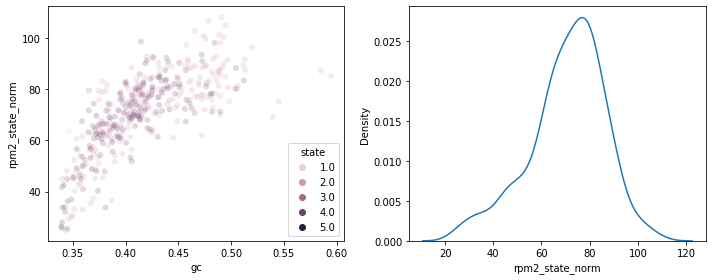

In [139]:
i = 0
for cell_id, cell_cn in bad_cn_s.groupby('cell_id'):
    
    fig, ax = plt.subplots(1, 1, figsize=(11.5, 4))
    plot_cell_cn_profile(ax, cell_cn, 'rpm2_state_norm', cn_field_name='state', rawy=True, chromosome="1")
    ax.set_ylabel('rpm2_state_norm')
    ax.set_title('{}'.format(cell_id))
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    sns.scatterplot(data=cell_cn, x='gc', y='rpm2_state_norm', hue='state', alpha=0.2, ax=ax[0])
    sns.kdeplot(data=cell_cn, x='rpm2_state_norm', ax=ax[1])
    plt.show()
    
    i += 1
    if i >= 10:
        break

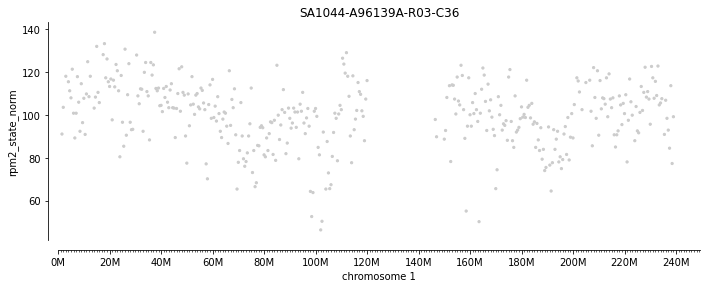

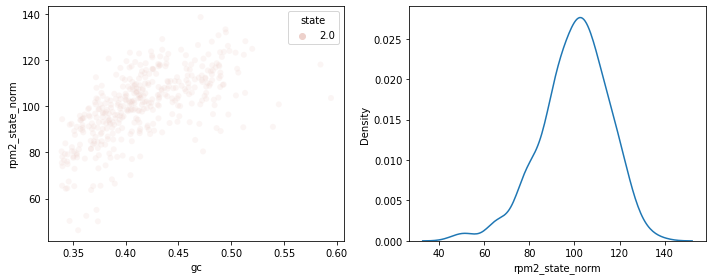

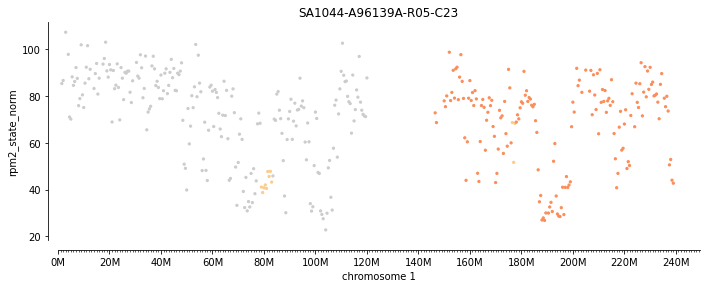

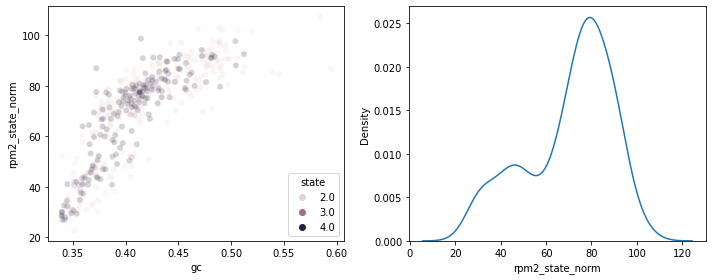

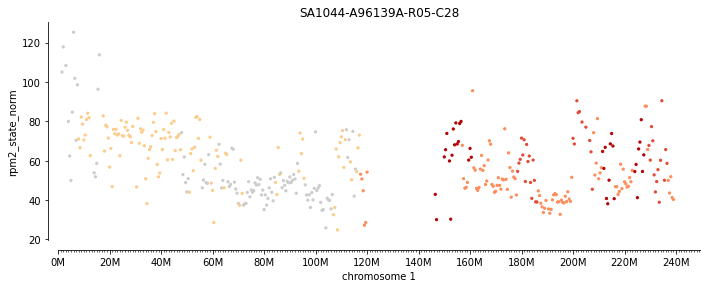

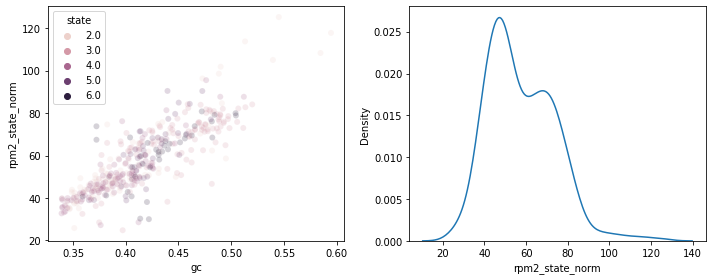

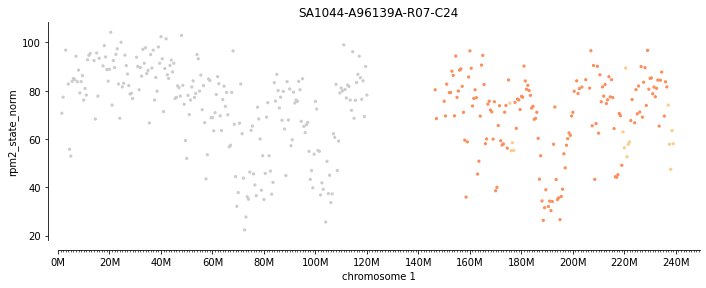

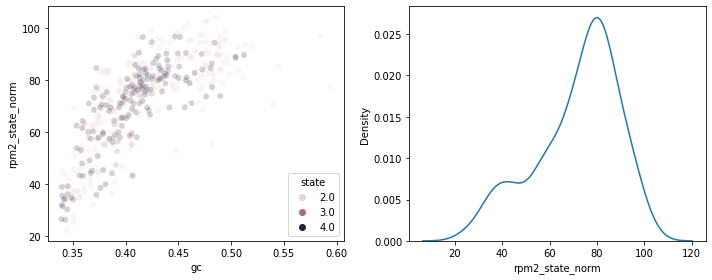

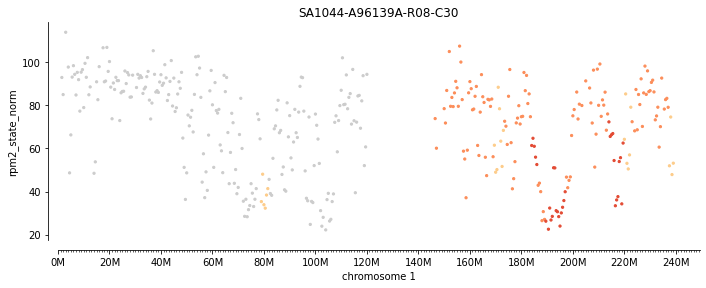

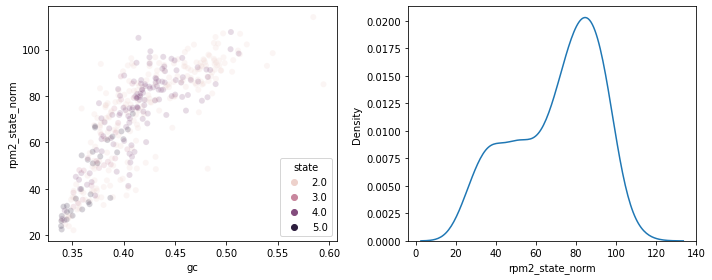

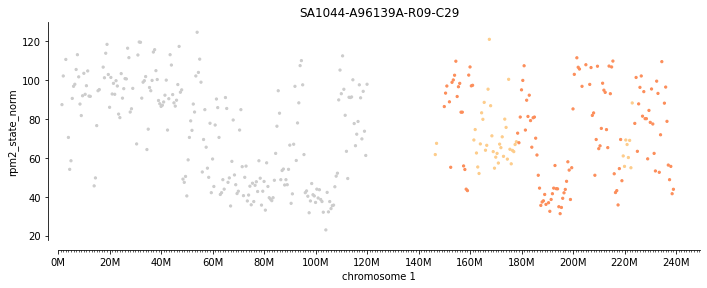

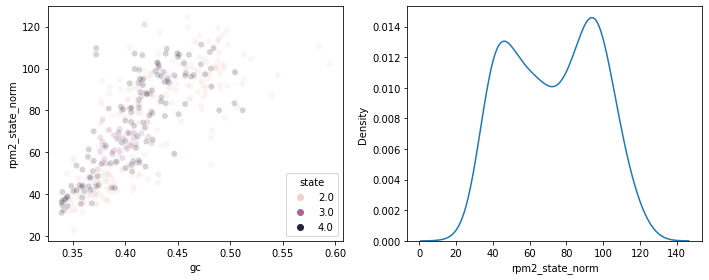

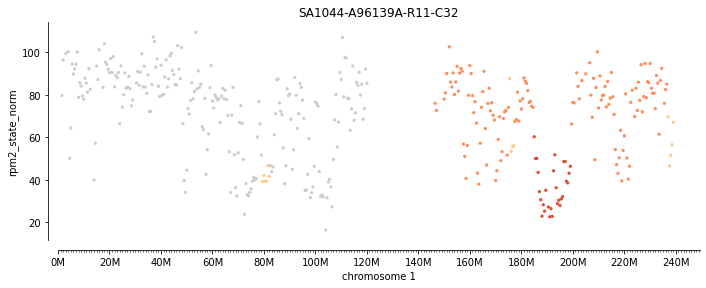

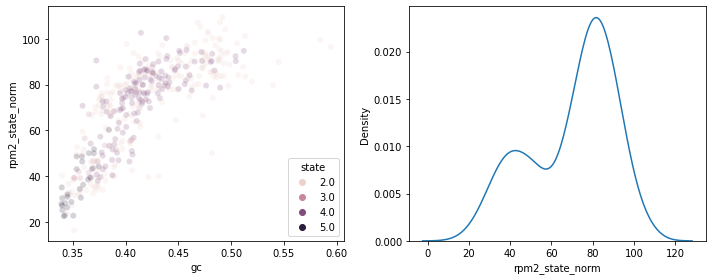

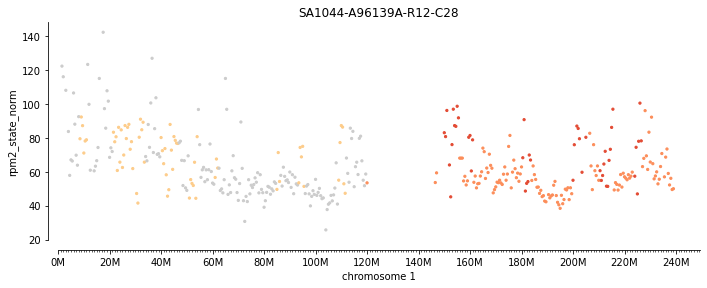

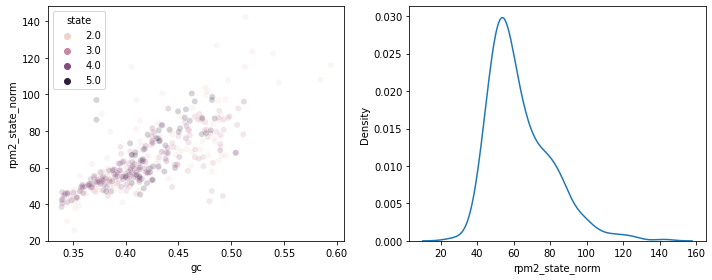

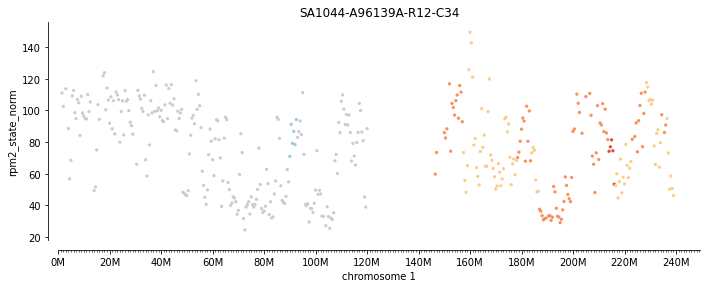

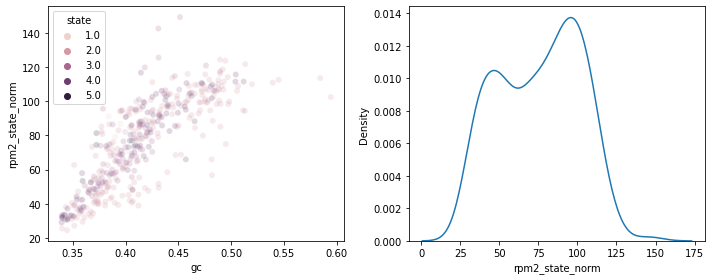

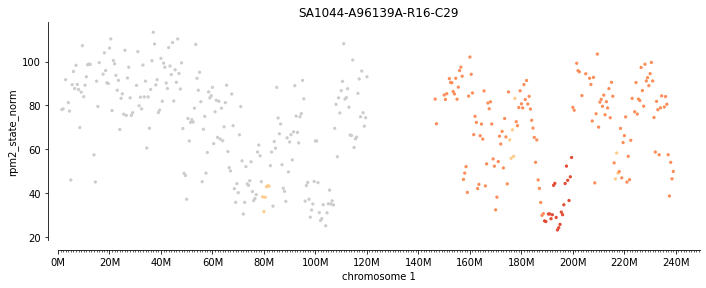

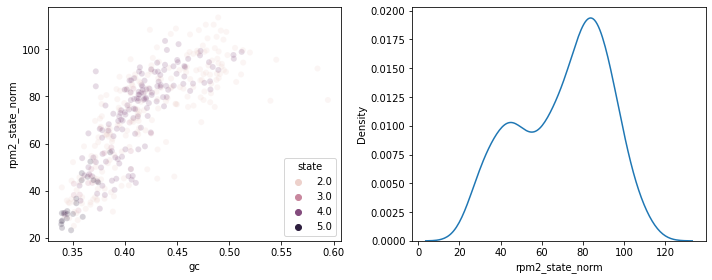

In [141]:
i = 0
for cell_id, cell_cn in good_cn_s.groupby('cell_id'):
    
    fig, ax = plt.subplots(1, 1, figsize=(11.5, 4))
    plot_cell_cn_profile(ax, cell_cn, 'rpm2_state_norm', cn_field_name='state', rawy=True, chromosome="1")
    ax.set_ylabel('rpm2_state_norm')
    ax.set_title('{}'.format(cell_id))
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    sns.scatterplot(data=cell_cn, x='gc', y='rpm2_state_norm', hue='state', alpha=0.2, ax=ax[0])
    sns.kdeplot(data=cell_cn, x='rpm2_state_norm', ax=ax[1])
    plt.show()
    
    i += 1
    if i >= 10:
        break

Nearly all of the "bad" cells have unimodal cn-normalized read count distributions whereas most of the good cells are bimodal. This makes me think that the "bad" cells are mostly flow sorting errors or are too close to the G1 or G2 border for the model to accurately infer the replication status of each bin.

### Run S-phase model again just using the "good" cells

In [142]:
cn_g1_reads_df, cn_g1_states_df, good_cn_s_reads_df, good_cn_s_states_df, \
    cn_g1_reads, cn_g1_states, good_cn_s_reads, good_cn_s_states, \
    gc_profile, rt_prior_profile, libs_g1, good_libs_s = process_input_data(good_cn_s, cn_g, input_col='rpm2')

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [143]:
# create cn prior for just the good cells

# # use G1-phase clone that has highest correlation to each S-phase cell as prior
# # compute consensuse clone profiles for cn state
# clone_cn_profiles = compute_consensus_clone_profiles(
#     cn_g, 'state', clone_col='clone_id', cell_col='cell_id', chr_col='chr',
#     start_col='start', cn_state_col='state'
# )

good_cn_prior_input = torch.zeros(good_cn_s_states.shape)

for i, cell_id in enumerate(good_cn_s_reads_df.columns):
    cell_cn = good_cn_s.loc[cn_s['cell_id']==cell_id]  # get full cn data for this cell
    cell_clone = cell_cn['clone_id'].values[0]  # get clone id
    good_cn_prior_input[:, i] = torch.tensor(clone_cn_profiles[cell_clone].values).to(torch.int64).to(torch.float32)  # assign consensus clone cn profile for this cell

# build a proper prior over num_states using the consensus clone cn calls for each cell
good_cn_prior = build_cn_prior(good_cn_prior_input)
good_cn_prior.shape


torch.Size([400, 223, 13])

In [152]:
pyro.clear_param_store()
pyro.set_rng_seed(15)  # change random seed to see if results change

optim_s5 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s5 = TraceEnum_ELBO(max_plate_nesting=2)

# condition model s4 using results from g3 (u fixed in g1-phase model)
conditioned_model_s5 = poutine.condition(
    model_s4,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit3,
        'beta_stds': beta_stds_fit3
    })

guide_s5 = AutoDelta(
    poutine.block(conditioned_model_s5,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi_s5 = SVI(conditioned_model_s5, guide_s5, optim_s5, loss=elbo_s5)


In [153]:
# Calculate initial loss

pyro.clear_param_store()

elbo_s5.loss(conditioned_model_s5, guide_s5, gc_profile, good_libs_s, data=good_cn_s_reads, cn_prior=good_cn_prior, t_init=t_init)


228776034304.0

In [154]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_s5.step(gc_profile, good_libs_s, data=good_cn_s_reads, cn_prior=good_cn_prior, t_init=t_init)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

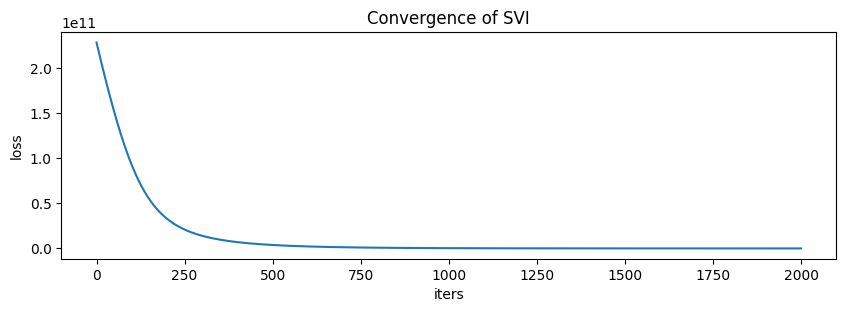

In [155]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


In [156]:
# Plot replicated state

guide_trace_s5 = poutine.trace(guide_s5).get_trace(gc_profile, good_libs_s, data=good_cn_s_reads, cn_prior=good_cn_prior, t_init=t_init)
trained_model_s5 = poutine.replay(conditioned_model_s5, trace=guide_trace_s5)

inferred_model_s5 = infer_discrete(
    trained_model_s5, temperature=0,
    first_available_dim=-3)
trace_s5 = poutine.trace(inferred_model_s5).get_trace(gc_profile, good_libs_s, data=good_cn_s_reads, cn_prior=good_cn_prior, t_init=t_init)

# extract fitted parameters
nb_r_fit_s5 = trace_s5.nodes['nb_r']['value']
u_fit_s5 = trace_s5.nodes['u']['value']
rt_fit_s5 = trace_s5.nodes['rt']['value']
a_fit_s5 = trace_s5.nodes['a']['value']
time_fit_s5 = trace_s5.nodes['t']['value']
model_rep5 = trace_s5.nodes['rep']['value']
model_cn5 = trace_s5.nodes['cn']['value']

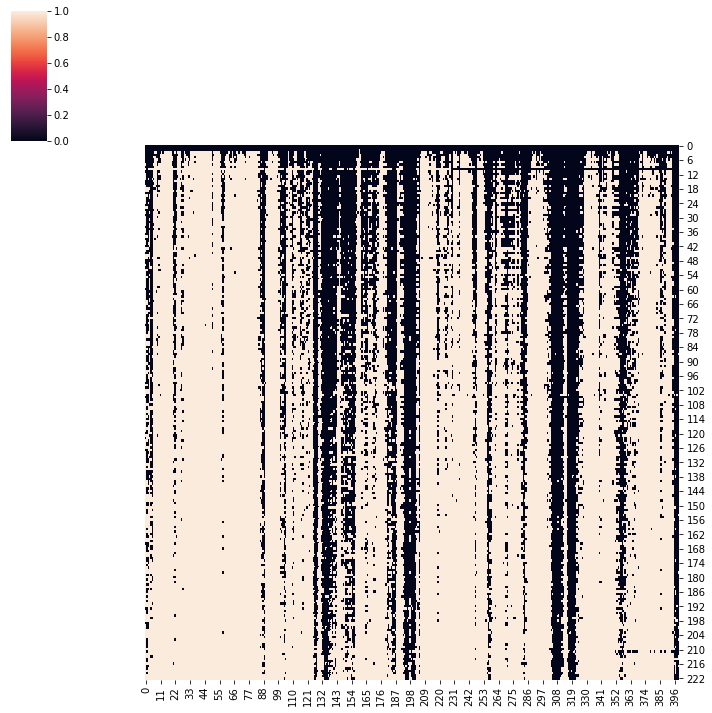

In [157]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep5.detach().numpy().astype(float).T[np.argsort(time_fit_s5.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

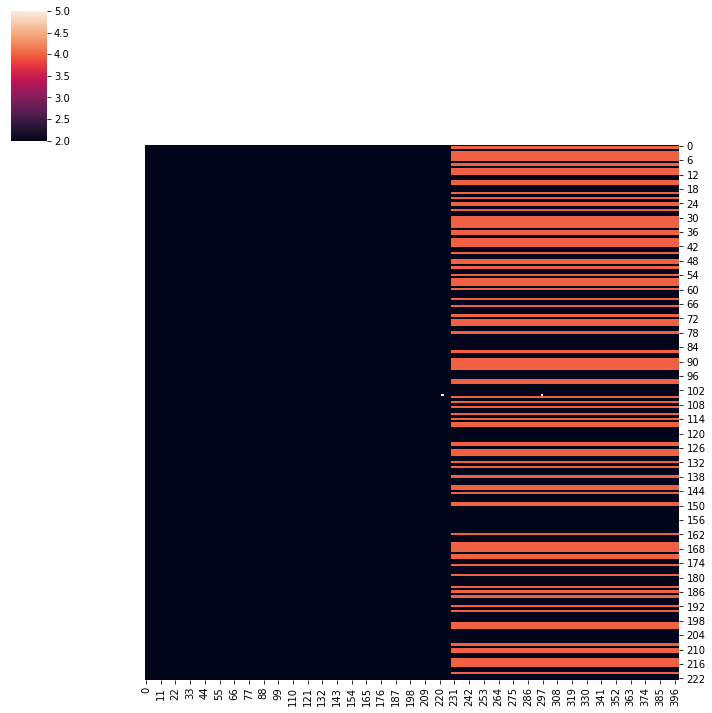

In [158]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn5.detach().numpy().astype(float).T[np.argsort(time_fit_s5.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

No new "bad" cells emerge when removing them from the model input and changing the random seed.

This makes me believe that these "bad" cells might not be replicating in the first place and removing them from downstream analysis is an appropriate practice.

One thing that needs to be determined is how to treat cells which might have a mix of replicating and non-replicating chromosomes (i.e. micronuclei, chrX inactivation, etc). Should we treat each chromosome from each cell as an independent sequence in order to detect cells that only have replication on a subset of chroms?